# IMPORTS AND DEFINITIONS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csaps
import os
from csaps import CubicSmoothingSpline as ss
from astropy.stats import sigma_clip
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

%matplotlib notebook
#%matplotlib inline

person_id = 'cchen' #please change this when ur initializing

In [2]:
#Check if target was normalized and file exists in norm folder
def dir_contains(target_name):
    dir_list = os.listdir('/media/rd3/cchen/cchen/kepler_ml_v3/2_normalize/lcs')
    file_exists = False
    all_files=[]
    for f in dir_list:
        if str(target_name) in f:
            all_files.append(f)
            file_exists = True

    if not file_exists:
        print("NO FILE EXISTS IN DIRLIST")
    else:
        print("ALL FILES: ")
        print(all_files)
        for filetouse in range(len(all_files)):
            loadpath = os.path.join('/media/rd3/cchen/cchen/kepler_ml_v3/2_normalize/lcs')
            loaded_file = np.load(loadpath, allow_pickle = True)
            file_origin =  loaded_file['origin'] 
            file_note1 =  loaded_file['note1'] 
            print("IDENTITY: " + str(filetouse))
            print(file_origin)
            print(file_note1)
def normalize_region(wl, flux, ferr, sds, plot_q=True, ss_smo=1e-3):
    
    __, gi = stdFiltIt(wl, np.copy(flux), 
                       np.ones_like(flux), 
                       sds, smo=ss_smo, plot_q=plot_q)

    cont_fit = csaps.CubicSmoothingSpline(wl[gi], 
                                                    flux[gi], 
                                                    smooth=ss_smo
                                                   )(wl)

    if plot_q:
        
        plt.figure(figsize=(10, 5))
        plt.plot(wl, flux, '.-k')
        plt.plot(wl, cont_fit, '-r')
        plt.title('Fit')
        plt.xlabel('time')
        plt.ylabel('Flux')
        
        plt.grid(1)
        
        plt.show()
    
    #####################################
    # Normalize continuum

    flux_norm = flux / cont_fit
    
    ferr_norm = ferr / cont_fit

    if plot_q:
        
        plt.figure(figsize=(10, 5))
        #plt.plot(wl, flux_norm, '.-k')
        plt.plot(wl, flux_norm, '-', c=[0.5, 0.5, 0.5], linewidth=1, label='Flux')
        
        if 1:
            plt.fill_between(wl, flux_norm - ferr_norm, flux_norm + ferr_norm, 
                             step='mid', 
                             color=[0.85, 0.85, 0.85], label='Flux Error')
        
        plt.axhline(1.0, color='m', linewidth=1, label='Continuum')
            
        plt.title('Normalized')
        
        plt.xlabel('time [day]')
        plt.ylabel('Flux [ppt]')
        
        plt.grid(1)
        
        plt.show()
    
    return cont_fit, flux_norm, ferr_norm


def wlr2ir(wl, wl_bounds):
    
    line_idx_bnds = [0, 0]

    line_idx_bnds[0] = np.argwhere(np.abs(wl - wl_bounds[0]) == np.nanmin(np.abs(wl - wl_bounds[0])))
    line_idx_bnds[1] = np.argwhere(np.abs(wl - wl_bounds[1]) == np.nanmin(np.abs(wl - wl_bounds[1])))

    # What indicies span within the wavelength bounds?
    return np.arange(line_idx_bnds[0], line_idx_bnds[1] + 1)


def stdFiltIt(wl, arr_1d, weights_1d, sdms, smo, plot_q):
    
    if plot_q:
        plt.figure(figsize=(10, 5))
        plt.title('Filter plot')
        plt.plot(wl, arr_1d, '.k')

    fit = arr_1d + np.nan
    
    for sdm in sdms:

        gi = np.logical_and(np.isfinite(weights_1d), np.isfinite(arr_1d))
        
        fit = csaps.CubicSmoothingSpline(wl[gi], arr_1d[gi], smooth=smo)(wl)

        dy_sd = np.std(arr_1d[gi] - fit[gi]) * sdm

        gi = np.logical_and(np.abs(arr_1d - fit) <= dy_sd, gi)

        if plot_q:
            plt.plot(wl[np.logical_not(gi)], arr_1d[np.logical_not(gi)], 'xr')
            plt.plot(wl, fit + dy_sd, ':g')
            plt.plot(wl, fit - dy_sd, ':r')
            plt.grid(True)

        arr_1d[np.logical_not(gi)] = np.nan

    if plot_q:
        plt.show()

    return arr_1d, gi

def mkdir(dir0):
    try:
        os.mkdir(dir0)
    except:
        print("FAILED MKDIR, DID SOMEONE ELSE ALREADY NORMALIZE THIS TARGET?")
        pass


def bjd2bkjd(bjd):
    
    return bjd - 2454833.0


def bkjd2bjd(bkjd):
    
    return bkjd + 2454833.0


def mask_mulit_transits(t0_bkjd, period_day, duration_day, time_bkjd, flux, 
                        lc=None, return_index=True):
    
    gi = ~np.ones(len(flux), dtype=bool)
    
    for p, t, d in zip(period_day, t0_bkjd, duration_day):
        
        
        gi0 = mask_transits(t, p, d, 
                            time_bkjd, flux, 
                            lc=None, return_index=True)
        
        #print(p, t, len(gi0) - np.sum(gi0))
        
                    
        gi = gi | gi0
                    
    return gi

def get_transit_times(t0_bkjd, period_day, duration_day, time_bkjd, flux):
    
    t0f_bkjd = np.copy(t0_bkjd)
   
    while t0f_bkjd > time_bkjd[0]:
       
        t0f_bkjd -= period_day
        
    #t0f_bkjd += period_day
        
    while t0f_bkjd < time_bkjd[0]:
       
        t0f_bkjd += period_day
        
    #t0f_bkjd -= period_day
       
    return np.arange(t0f_bkjd, time_bkjd.max(), step=period_day)
    

def mask_transits(t0_bkjd, period_day, duration_day, time_bkjd, flux, 
                  lc=None, return_index=True):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
       
    if lc != None:
        
        time_bkjd = np.array(lc.astropy_time.value)

        flux = lc.flux
   
    t0f_bkjd = np.copy(t0_bkjd)
      
    tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day, time_bkjd, flux)
   
    # For each tranist find all datapoints within the tranist duration window
   
    ntot_idx = np.ones(len(flux), dtype=bool)
   
    for tot in tots_bkjd:
       
        tot_idx = (time_bkjd > tot - duration_day / 2) & (time_bkjd < tot + duration_day / 2)
       
        ntot_idx = ntot_idx & ~tot_idx
    
    if return_index:
        return ~ntot_idx # Returns where transits occur
    else:
        return time_bkjd[ntot_idx], flux[ntot_idx]


def plot_transits_v0(t0_bkjd, period_day, duration_day, time_bkjd, flux):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
   
    #time_bkjd = np.array(lc.astropy_time.value)
    
#     if time_bkjd[0] > 2400000.5:
        
#         time_bkjd = time_bkjd - 2400000.5
   
    #flux = lc.flux
   
    t0f_bkjd = np.copy(t0_bkjd)
   
    tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day, time_bkjd, flux)
   
    # For each tranist find all datapoints within the tranist duration window
   
    ntot_idx = np.ones(len(flux), dtype=bool)
   
    for tot in tots_bkjd:
       
        tot_idx = (time_bkjd > tot - duration_day / 2) & (time_bkjd < tot + duration_day / 2)
       
        ntot_idx = ntot_idx & ~tot_idx
        
        plt.axvline(tot, c='r')
       
    plt.plot(time_bkjd[ntot_idx], flux[ntot_idx], '.k')
    plt.plot(time_bkjd[~ntot_idx], flux[~ntot_idx], '.r')
    
    plt.xlabel('time [day]')
    plt.ylabel('flux [ppt]');
    plt.show(block=0)
    
    
def plot_mp_transits_v0(t0_bkjd0, period_day0, duration_day, time_bkjd, flux, toi):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
    
    t0f_bkjd0 = np.copy(t0_bkjd0)
   
    plt.figure(figsize=(10, 5))
    #plt.plot(time_bkjd, flux, '.r')
    cw = ['r','g','c', 'b', 'm']
    
    for it in np.arange(len(period_day0)):
        
        #print(it, period_day0, t0f_bkjd0)
        
        period_day, t0f_bkjd = period_day0[it], t0f_bkjd0[it]

        tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day[it], time_bkjd, flux)

        # For each tranist find all datapoints within the tranist duration window
        ntot_idx = np.ones(len(flux), dtype=bool)

        for tot in tots_bkjd:

            tot_idx = (time_bkjd > tot - duration_day[it] / 2) & (time_bkjd < tot + duration_day[it] / 2)

            ntot_idx = ntot_idx & ~tot_idx

            plt.axvline(tot, c=cw[it % 5])

        if it == 0:
            plt.plot(time_bkjd[ntot_idx], flux[ntot_idx], '.k')
            
        if it == toi:
            plt.plot(time_bkjd[~ntot_idx], flux[~ntot_idx], '.', c=cw[it % 5], 
                     label='P='+ str(np.around(period_day, 1)) + '  t0='+ str(np.around(t0f_bkjd, 1)) + '  d='+ str(np.around(duration_day[it], 3)) + ' (TOI)')
        
        else:
            plt.plot(time_bkjd[~ntot_idx], flux[~ntot_idx], '.', c=cw[it % 5], 
                     label='P='+ str(np.around(period_day, 1)) + '  t0='+ str(np.around(t0f_bkjd, 1)) + '  d='+ str(np.around(duration_day[it], 3)))
        

    plt.legend()
    plt.xlabel('time [day]')
    plt.ylabel('flux [ppt]');
    plt.show(block=0)

def meas_bic(flux, cont_fit):

    sigma = np.median(np.diff(flux)) * 1.48 / np.sqrt(2)


    ssr = np.sum( (flux - cont_fit)**2 )


    npoints = len(flux)


    penalty_coeff = 1.0


    nparams = 1.0 # number of knots + degree of spline - 1

    # The following term is -2*ln(L), where L is the likelihood of the data
    # given the model, under the assumption that the model errors are iid
    # Gaussian with mean 0 and standard deviation sigma.
    likelihood_term = npoints * np.log(2 * np.pi * sigma**2) + ssr / sigma**2

    # Bayesian information criterion.
    bic = likelihood_term + penalty_coeff * nparams * np.log(npoints)
    
    return bic



def meas_sigdif(time, flux, weights, cont_fit, sigma_i):

    #df = flux / cont_fit
    
    #sigma_f = np.std(np.diff(df)) #* 1.48 / np.sqrt(2)
    
    sigma_f = meas_sig(time, flux / cont_fit, weights, plot_q=0)
    
    return (sigma_i - sigma_f)**2

def split(all_time, all_flux, gap_width=0.75, dft=0.05, index_only=False):
    """Splits a light curve on discontinuities (gaps).
    This function accepts a light curve that is either a single segment, or is
    piecewise defined (e.g. split by quarter breaks or gaps in the in the data).
    Args:
    all_time: Numpy array or list of numpy arrays; each is a sequence of time
        values.
    all_flux: Numpy array or list of numpy arrays; each is a sequence of flux
        values of the corresponding time array.
    gap_width: Minimum gap size (in time units) for a split.
    Returns:
    out_time: List of numpy arrays; the split time arrays.
    out_flux: List of numpy arrays; the split flux arrays.
    """
    
    import collections
    
    if index_only:
        idx = np.arange(len(all_time), dtype=int)
    
    # Handle single-segment inputs.
    # We must use an explicit length test on all_time because implicit conversion
    # to bool fails if all_time is a numpy array, and all_time.size is not defined
    # if all_time is a list of numpy arrays.
    if len(all_time) > 0 and not isinstance(all_time[0], collections.Iterable):  # pylint:disable=g-explicit-length-test
        
        all_time = [all_time]
        all_flux = [all_flux]

    out_time = []
    out_flux = []
    out_idx = []
    for time, flux in zip(all_time, all_flux):

        start = 0

        for end in range(1, len(time) + 1):

            splitit = 0
            # Choose the largest endpoint such that time[start:end] has no gaps.
            if end == len(time):
                splitit = 1
                
            elif (time[end] - time[end - 1] > gap_width):
                splitit = 1
                
            elif np.abs(flux[end] - flux[end - 1]) > dft:
                splitit = 1

            if splitit:
                
                if index_only:
                    out_idx.append(idx[start:end])
                else:
                    out_time.append(time[start:end])
                    out_flux.append(flux[start:end])
                start = end

    if index_only:
        return out_idx
    else:
        return out_time, out_flux
    
def meas_sig(time, flux, weights, plot_q=False):
    
    df0 = np.diff(flux)
    
    #df = sigma_clip(df0, sigma=8, maxiters=1)
    
    #df = sigma_clip(df, sigma=5, maxiters=2)
    
    #df = sigma_clip(df, sigma=3, maxiters=2)
    
    gi = np.ones(len(df0), dtype=bool)
    
    for sdm in [8, 5, 3]:
        
        sd = np.std(df0[gi])
        
        gi = gi & ((df0 > -sd * sdm) & (df0 < sd * sdm))
    
    
    if plot_q:
        
        x = np.copy(time[:-1])
        
        #__, gi, __ = np.intersect1d(df0, df, return_indices=1)
        
        #gi = np.sort(gi)
        
        plt.figure(figsize=(10, 4))
        plt.title(str(np.median(np.abs(df0))))
        plt.plot(x, df0, '.k', label='Orig dF')
        plt.plot(x[gi], df0[gi], '.g', label='Final dF')
        plt.legend()
        
    return np.median(np.abs(df0[gi]))
        

def meas_sig_old(time, flux, weights, plot_q=False):
    
    from astropy.stats import sigma_clip
    
    df = np.diff(flux)
    
    x = np.copy(time[:-1]) #np.arange(len(df))
    
    dff1 = csaps.CubicSmoothingSpline(x, 
                                                df, 
                                                smooth=0.1,
                                                weights=weights[:-1],
                                                )(x)

    
#     print('dff1', dff1)
    
    dfn = df - dff1
    
    dfnf = np.copy(dfn)
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(x, df, '.k', label='Orig dF')
#     plt.plot(x, dff1, '-c', label='dF fit 1')
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(x, dfn, '.k', label='Orig dF')

    for sd in [5]:

        dfnf = sigma_clip(dfnf, sigma=sd, maxiters=2)

    __, gi, __ = np.intersect1d(dfn, dfnf, return_indices=1)

    gi = np.sort(gi)
    
    
#     plt.figure(figsize=(10, 4))
#     plt.plot(x[gi], dfn[gi], '.k', label='Orig dF')
    
#     try:

    dff = csaps.CubicSmoothingSpline(x[gi], 
                                                df[gi], 
                                                smooth=0.1,
                                                weights=weights[:-1][gi],
                                                )(x)
#     except:
        
#         print('FAIL', len(x), len(gi))
        
#         #FAIL 271 270 36338 -36608
#         #FAIL 271 270 36338 -36608
        
#         return

    dfn = df - dff

    if plot_q:
        plt.figure(figsize=(10, 4))
        plt.plot(x, df, '.k', label='Orig dF')
        plt.plot(x, dff1, '-c', label='dF fit 1')
        plt.plot(x, dff, '-m', label='dF fit 2')
        plt.legend()
    
    
    for sd in [5, 3]:
        
        dfn = sigma_clip(dfn, sigma=sd, maxiters=5)

    if plot_q:
        plt.figure(figsize=(10, 7))
        plt.title('RMS = ' + str(np.std(dfn)))
        plt.plot(x, dfn, '.k')
        
    return np.std(dfn)
def filt_ssfit(time, flux, weights, gi_mask, smo, sds, return_filt_index=False, plot_q=False):
    
    from csaps import CubicSmoothingSpline as ss
    
    flux_fit = ss(time[gi_mask], flux[gi_mask], smooth=smo, weights=weights[gi_mask])(time)

    df = flux - flux_fit

    dff = np.copy(df)

#     for sd in sds:

#         dff = sigma_clip(dff, sigma=sd, maxiters=3)

#     __, gi, __ = np.intersect1d(df, dff, return_indices=1)

#     gi = np.sort(gi)
    
#     bi = np.ones(len(time), dtype=bool)
#     bi[gi] = False
#     gi = ~bi

    gi = np.copy(gi_mask)
    
    gi_cnt_0 = np.sum(gi)

    for sdm in sds:

        sd = np.std(dff[gi])

        gi_new = ((dff > -sd * sdm) & (dff < sd * sdm))
        
        if np.sum(gi_new) < gi_cnt_0 * 0.5:
            
            print('Filter might be too strong. Attempted to filter >50% of the points in a section. Not applying this filter.')
            break
        
        gi = gi & gi_new
        
    
    # Apply mask
    #gi = gi & gi_mask
    bi = ~gi
    
    cf = ss(time[gi], flux[gi], smooth=smo, weights=weights[gi])(time)
    
    if plot_q:
        
        # Show the filter plot
        plt.figure(figsize=(10, 7))
        plt.title('Filter Stage (single)')
        plt.plot(time, flux, '.k')
        plt.plot(time[bi], flux[bi], 'xr')
        plt.plot(time, cf, '-m')
        plt.show()
        plt.pause(0.1)

    if return_filt_index:
        return cf, bi
    else:
        return cf

    
def iter_filt_ssfit(time, flux, weights, gi_mask, smo, sds, iters=3, return_filt_index=False, plot_q=False, save_plot_q=False):
    
    time2, flux2 = np.copy(time), np.copy(flux)
    
    gi = np.copy(gi_mask) #ones(len(time), dtype=bool)
    
    for i in range(iters):
        
        cf, bi = filt_ssfit(time2, flux2, weights, 
                            gi, smo, sds, 
                            return_filt_index=True, 
                            plot_q=0)
        
        gi = ~bi
        
        
    if plot_q:
        
        # Show the filter plot
        fig = plt.figure(figsize=(10, 7))
        plt.title('Filter Stage')
        plt.plot(time, flux, '.k')
        plt.plot(time[~gi_mask], flux[~gi_mask], '.', c=[0,1,0,0.8])
        plt.plot(time[~gi & gi_mask], flux[~gi & gi_mask], 'xr')
        plt.plot(time, cf, '-m')
        plt.show()
        #plt.pause(0.1)
        
    if return_filt_index:
        if save_plot_q:
            return cf, ~gi, fig
        return cf, ~gi
    else:
        if save_plot_q:
            return cf, fig
        return cf
    
def normlc(time, flux, smooth_params_to_try, fit_sds, time_gap_thresh, 
           mask_transit_q, t0, p, duration, 
           flux_gap_thresh=0.005, plot_q=False):
    
    
    ####################################################################################
    # Split the light curve into sections based on time and flux gaps 
    
    all_time, all_flux = split(time, flux, 
                               gap_width=time_gap_thresh, 
                               dft=flux_gap_thresh)

    print('Data broken into ' + str(len(all_time)) + ' sections')

    if plot_q:
        
        plt.figure(figsize=(10, 7))
        plt.title('Data broken into ' + str(len(all_time)) + ' sections')

        for ci in np.arange(len(all_flux)):

            plt.plot(all_time[ci], all_flux[ci], '.')
        
        plt.show()
        plt.pause(1.0)
        
        
    # Cut sections that are lest than 50 points long
    cnt = np.array([len(all_time[i]) for i in range(len(all_time))])
    
    gi = cnt > 30
    
    all_time0, all_flux0 = np.copy(all_time), np.copy(all_flux)
    
    all_time, all_flux = [], []
    for i in np.arange(len(all_time0)):
        
        if gi[i]:
            all_time.append(all_time0[i])
            all_flux.append(all_flux0[i])
        
        

    ####################################################################################
    # Fit each section
    
    smos = np.copy(smooth_params_to_try) #np.linspace(0.999, 1-1e-10, 200)
    
    cont_fit, time_norm, flux_norm, outliers = np.array([]), np.array([]), np.array([]), np.array([])
    cont_fit_list, flux_norm_list, outliers_list = [], [], []
    
    for cn in range(len(all_time)):
    #for cn in range(1):

        # Mask the transit
        if mask_transit_q:
            
            transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
                                        time_bkjd=all_time[cn], 
                                        flux=all_flux[cn], 
                                        lc=None, return_index=True)
        else:

            transit_idx = np.zeros(len(all_time[cn]), dtype=bool)
            

        weights = np.float64(~transit_idx)
        
        weights[weights==0.0] = 1e-5
        
        bics = np.ones_like(smos)

        sigma = meas_sig(all_time[cn][~transit_idx], all_flux[cn][~transit_idx], weights, plot_q=0)

        for i, smo in enumerate(smos):

            # Make the fit
            cont_fit_tmp = iter_filt_ssfit(all_time[cn], 
                                           all_flux[cn], weights, 
                                           ~transit_idx, 
                                           smo, sds=fit_sds, 
                                           return_filt_index=0, 
                                           plot_q=0)
            
            # Measure the fit reliabillity based on some metric
            bics[i] = meas_sigdif(all_time[cn][~transit_idx], 
                                  all_flux[cn][~transit_idx], 
                                  cont_fit_tmp[~transit_idx], 
                                  sigma_i=sigma)


        # Determine the best smoothing param
        bv = np.argmin(bics)

        idx = np.arange(3) - 1

        idx = bv + idx

        pf_fail = True
        if (idx[0] < 0) | (idx[-1] > len(smos)-1):
            
            bsmo = smos[bv]
            
        else:
            
            pfc = np.polyfit(smos[idx], bics[idx], 2)

            bsmo = - pfc[1] / (2 * pfc[0])
            
            pf_fail = False

        
        if 0:#plot_q:

            plt.figure(figsize=(10, 7))
            plt.title('Sigma difference results  |  Section ' + str(cn) + ' | Best smoothing param = ' + str(bsmo))
            plt.plot(smos, bics, '.k', label='Sigma')
            
            if not pf_fail:
                plt.plot(smos[idx], np.polyval(pfc, smos[idx]), '-m', label='Sigma fit')
                plt.plot(bsmo, np.polyval(pfc, bsmo), '*g', label='Best match')
                
            plt.show()
            
        
        # Make the final fit using the solved smoothing param
        cont_fit_tmp, outliers_tmp = iter_filt_ssfit(all_time[cn], 
                                                     all_flux[cn], 
                                                     ~transit_idx, 
                                                     bsmo, sds=fit_sds, 
                                                     return_filt_index=1, 
                                                     plot_q=0)
        
        
        flux_norm_tmp = all_flux[cn] / cont_fit_tmp
        
        
        cont_fit_list.append(cont_fit_tmp)
        
        flux_norm_list.append(flux_norm_tmp)
        
        outliers_list.append(outliers_tmp)
        
        
        time_norm = np.concatenate((time_norm, all_time[cn]))
        
        cont_fit = np.concatenate((cont_fit, cont_fit_tmp))
        
        flux_norm = np.concatenate((flux_norm, flux_norm_tmp))
        
        outliers = np.concatenate((outliers, outliers_tmp))
        
        
    if plot_q:
        
        # Mask the transit
        if mask_transit_q:

            transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
                                        time_bkjd=time_norm, flux=flux_norm, 
                                        lc=None, return_index=True)
        else:

            transit_idx = np.zeros(len(all_time[cn]), dtype=bool)

        plt.figure(figsize=(10, 7))
        
        #plt.plot(time_norm, flux_norm, '.k')
        plt.plot(time_norm, flux_norm, '.k')
        
        if mask_transit_q:
            plt.plot(time_norm[transit_idx], flux_norm[transit_idx], '.', 
                     c=[0,1,0,0.8], label='Transit (Area Masked During Fit)')
        
        plt.grid(1)
        plt.show()
        
    return time_norm, flux_norm, cont_fit, outliers

def rms(y):

    gi = np.isfinite(y)

    y = y[gi]

    return np.sqrt(np.mean(y ** 2))

def manual_split(split_time_arr):
    global all_time
    global all_flux
    for split_time in split_time_arr:
        for i in range(len(all_time)):
            if (split_time < max(all_time[i])) and (split_time > min(all_time[i])) :
                temp_time = np.array(all_time[i])
                temp_flux = np.array(all_flux[i])
                temp_time_1 = []
                temp_time_2 = []
                temp_flux_1 = []
                temp_flux_2 = []
                for j in range(len(temp_time)):
                    if (temp_time[j] <= split_time):
                        temp_time_1.append(temp_time[j])
                        temp_flux_1.append(temp_flux[j])
                    else:
                        temp_flux_2.append(temp_flux[j])
                        temp_time_2.append(temp_time[j])
                if len(temp_time_1) > 0:
                    all_time[i] = np.array(temp_time_1)
                    all_flux[i] = np.array(temp_flux_1)
                if len(temp_time_2) > 0:
                    all_time.insert(i+1, np.array(temp_time_2))
                    all_flux.insert(i+1, np.array(temp_flux_2))
                break
                    
                    
def manual_splice(a,b):
    global all_time
    global all_flux
    for i in range(len(all_time)):
        bad_ind = np.logical_and(all_time[i] >= a, all_time[i] <= b)
        #print(np.array(bad_ind))
        #print(i)
        all_time[i] = all_time[i][~np.array(bad_ind)]
        all_flux[i] = all_flux[i][~np.array(bad_ind)]
    for i in range(len(all_time)):
        if len(all_time[i]) <= 1:
            all_time.pop(i)
            all_flux.pop(i)
            
def delete_section(a):
    global all_time
    global all_flux
    #print(all_time,all_flux)
    all_time.pop(a)
    all_flux.pop(a)
    #print(len(all_flux))
    
def min_smo_OLD(smo, time, flux, weights, transit_idx, fit_sds, sigma, vs):
    
    global smo_h, lsq_h
    
    smo = smo / vs
    
    #print(smo)
    
    # Make the fit
    cont_fit_tmp = iter_filt_ssfit(time, 
                                   flux, 
                                   weights, 
                                   ~transit_idx, 
                                   smo, 
                                   sds=fit_sds, 
                                   return_filt_index=0, 
                                   plot_q=0)

    # Measure the fit reliabillity based on some metric
#     bics = meas_sigdif(time, 
#                        flux, 
#                        weights, 
#                        cont_fit_tmp, 
#                        sigma_i=sigma)

    sigma_f = rms(flux - cont_fit_tmp)
    
    bics = (sigma - sigma_f)**2
    
    smo_h.append(smo)
    lsq_h.append(bics)
    
    return bics


def min_smo(smo, time, flux, weights, transit_idx, fit_sds, sigma, vs, t_bins0):
    
    global smo_h, lsq_h
    
    smo = smo / vs
    
    # Make the fit
    cont_fit_tmp, bi = iter_filt_ssfit(time, 
                                       flux, 
                                       weights, 
                                       ~transit_idx, 
                                       smo, 
                                       sds=fit_sds, 
                                       return_filt_index=1, 
                                       plot_q=0)
    
    gif = ~bi
    
    t_bins = t_bins0[gif]
    
    df = flux[gif] - cont_fit_tmp[gif]
    
    sigma_f = rms(df)
    
    dtb = np.zeros(np.max(t_bins)+1, dtype=float)
    
    for i in range(np.max(t_bins)+1):
        
        gi = t_bins == i
        
        ti = df[gi] > 0
        bi = df[gi] < 0
        
        #dtb[i] = np.abs(np.sum(df[gi][ti]) + np.sum(df[gi][bi]))
        
        a = np.sum(df[gi][ti]) + 1e-6
        
        b = np.sum(df[gi][bi]) + 1e-6
        
        dtb[i] = np.abs(1 - np.abs(a / b))
        
    w1 = 100
    #c1 = (sigma - sigma_f)**2
    c1 = np.abs(1 - np.abs(sigma + 1e-6 / (sigma_f + 1e-6)))
    
    w2 = 1
    #c2 = np.sum(dtb)
    c2 = np.sum(dtb) / len(dtb)
    
    #print(c1, c2, smo, np.sum(dtb) , len(dtb))
    
    #bics = w1 * c1 + w2 * c2
    
    bics = c1 * 1.0 + c2 * 1.0 + smo * 0.5  #**1.3036
    
    #bics = c1 * c2#$* np.abs(smo - 0.5)**0.1  #**1.3036
    
    #bics = np.sum(dtb)
    
    c1_h.append(c1)
    c2_h.append(c2)
    smo_h.append(smo)
    lsq_h.append(bics)
    
    return bics
    

# Or download a light curve

**Search for data of a specific target**

In [3]:
import pandas as pd
table = pd.read_excel('/media/rd3/cchen/cchen/kepler_ml_v3/2_normalize/KeplerCumulative2.xlsx')
table


kepid_search_arr = pd.read_excel("/media/rd3/cchen/cchen/kepler_ml_v3/2_normalize/kepid_list.xlsx")
#kepid_search_arr = pd.read_excel("/media/rd1/hwei/class_rv_lc/usp_kepid_list.xlsx")
kepid_search_arr

kepid_list = kepid_search_arr['kepid'][:]

kepler_kics = table['kepid'][:]
kepler_koi = [float(e[1:]) for e in table['kepoi_name']]
kepler_t0_bjd = table['koi_time0'][:]
kepler_period_day = table['koi_period'][:]
kepler_duration_day = table['koi_duration'][:]/24.

In [4]:
all_t0_bkjd = []
all_period_day = []
all_duration_day = []
interest_idx = - 1


#I just did this for USP catalog only, you can modify it for other catalogs as well

# x = 1207
x = 74

target_name = kepid_list[x] #Must be an KIC integer
print("TARGET NUMBER: " + str(x))
print("TARGET KEPID: " + str(target_name))

print("\nList of Planets in System:")
for i in range(len(kepler_kics)):
    if (kepler_kics[i] == target_name):
        print(kepler_koi[i])
        all_t0_bkjd.append(kepler_t0_bjd[i])
        all_period_day.append(kepler_period_day[i])
        all_duration_day.append(kepler_duration_day[i])

interest_idx = -69

print("\nALL T0s:")
print(all_t0_bkjd)
print("ALL Periods")
print(all_period_day)
print("ALL Duration")
print(all_duration_day)
print("Interest ID")
print(interest_idx)

fig_dir = os.path.join('/media', 'rd3', 'cchen', 'cchen', 'kepler_ml_v3', '2_normalize', 'normalized_plots', str(target_name))
mkdir(fig_dir)
dir_contains(target_name)

TARGET NUMBER: 74
TARGET KEPID: 6276477

List of Planets in System:
849.01

ALL T0s:
[2455003.937]
ALL Periods
[10.35533116]
ALL Duration
[0.13239583333333335]
Interest ID
-69
NO FILE EXISTS IN DIRLIST


In [5]:
for i in range(len(all_t0_bkjd)):
    
    t0i = all_t0_bkjd[i]
    
    if t0i < 1e4:
        
        all_t0_bkjd[i] = bkjd2bjd(t0i)
print(all_t0_bkjd)

[2455003.937]


In [6]:
from lightkurve.lightcurve import LightCurve
from astropy.io import fits
from lightkurve.search import search_lightcurvefile

# lc_file = fits.open('/media/rd1/hwei/downloaded_kepids/' +'KIC'+ str(target_name) + '.fits')

res = search_lightcurvefile(target_name, radius=None, 
                            cadence='long', #
                            #cadence='short', 
                            mission=('Kepler'),#, 'K2', 'TESS'), 
                            quarter=None, month=None, 
                            campaign=None, 
                            #campaign=16, 
                            sector=None, 
                            limit=None,
                            #limit=10,
                           )

lc = res.download_all(quality_bitmask='hard')

try:
    lc = lc.PDCSAP_FLUX.stitch()
except:
    pass

# print("ORIGINAL KEPID: " + str(target_name))
# lc_file.info() # there should be just two entires, 0 and 1, but check to be sure theres not a third one (2)
# print(len(lc_file[1].data.TIME))

# lc = LightCurve(lc_file[1].data.TIME, lc_file[1].data.FLUX, lc_file[1].data.FLUX_ERR, time_format = 'bkjd')
# lc

lc = lc.remove_nans()

time, flux, flux_err = lc.time, lc.flux, lc.flux_err

if 1:
    time = np.array(lc.astropy_time.value)# - 2400000.5

In [37]:
print(flux_err)
# print(flux)

# print(np.std(flux))
# print(np.var(flux))
print()

[0.00030629 0.00030646 0.00030643 ... 0.00030885 0.00030715 0.00030523]
6.980328e-07


In [33]:
# Determine time gap threshold

print('Time Stats:\nMin = ' + str(np.nanmin(np.diff(time))) +
      '\nMax = ' + str(np.nanmax(np.diff(time))) +
      '\nMedian = ' + str(np.nanmedian(np.diff(time))) +
      '\nSD = ' + str(np.nanstd(np.diff(time))))

#time_gap_thresh = np.nanstd(np.diff(time)) * 10
time_gap_multiplier = 3
time_gap_thresh = np.nanmedian(np.diff(time)) * time_gap_multiplier
print("BE CAREFUL, THE TIME GAP MULTIPLIER IS " + str(time_gap_multiplier) + " WHEN THE ORIGINAL WAS 3")


print(time_gap_thresh)

Time Stats:
Min = 0.0204284037463367
Max = 15.835588049143553
Median = 0.020433685276657343
SD = 0.10302781748472384
BE CAREFUL, THE TIME GAP MULTIPLIER IS 3 WHEN THE ORIGINAL WAS 3
0.06130105582997203


In [35]:
#time_gap_thresh = np.nanstd(np.diff(np.array(lc.astropy_time.value))) * 10
#scroll across the plot to see, i made it very long so it was easier.
# all_time, all_flux = split(time, flux,  
#                            gap_width=time_gap_thresh * 10, 
#                            dft=np.std(lc.flux) * 10)

all_time, all_flux = split(time, flux,  
                           gap_width=time_gap_thresh * 10, 
                           dft=np.std(lc.flux) * 10)

#print(all_time)
# all_time, all_flux = split(time, flux,  
#                            gap_width=time_gap_thresh * 3, 
#                            dft=np.std(lc.flux) * 3)

<ipython-input-2-50f509d3b919>:354: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  if len(all_time) > 0 and not isinstance(all_time[0], collections.Iterable):  # pylint:disable=g-explicit-length-test


In [36]:
print(len(all_time))
print(len(all_flux))
print(len(flux_err))

56
56
62441


In [149]:
target_name

10554999

Data broken into 45 sections
Data broken into 45 sections
0


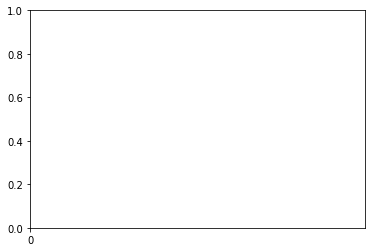

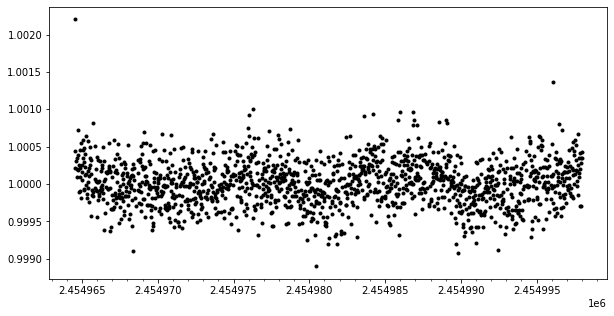

1


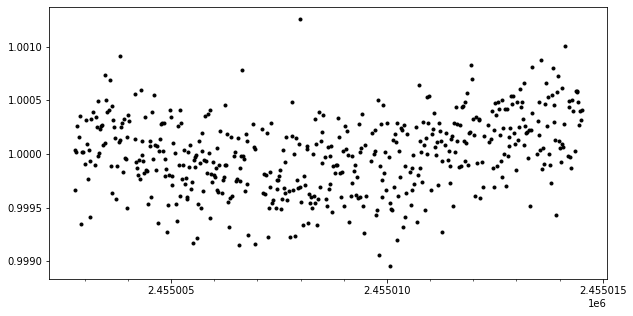

2


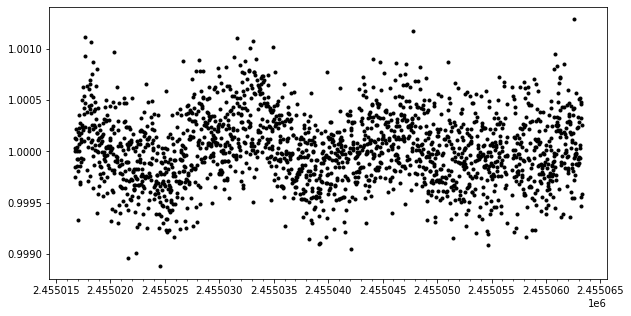

3


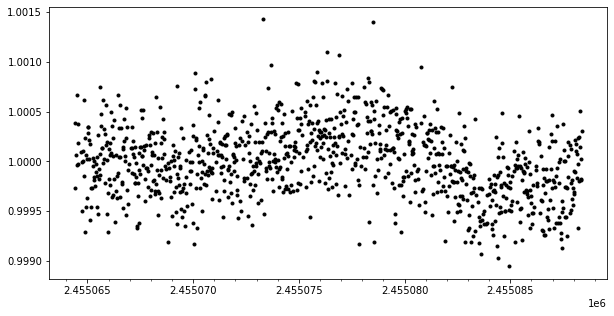

4


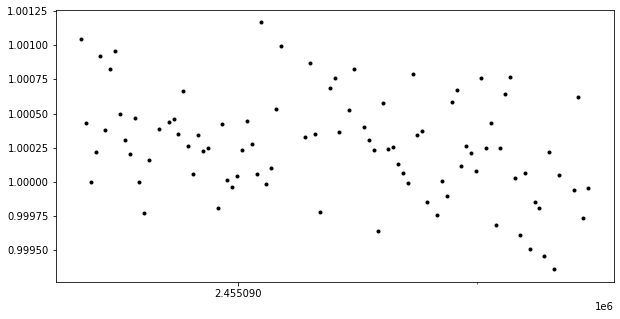

5


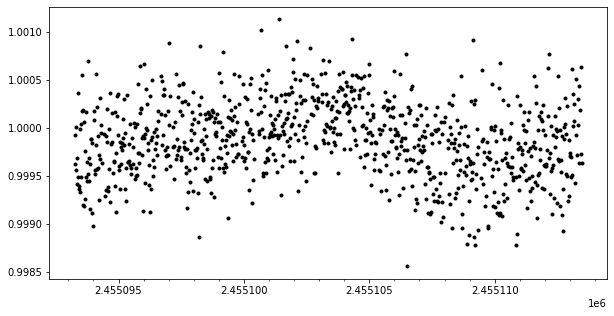

6


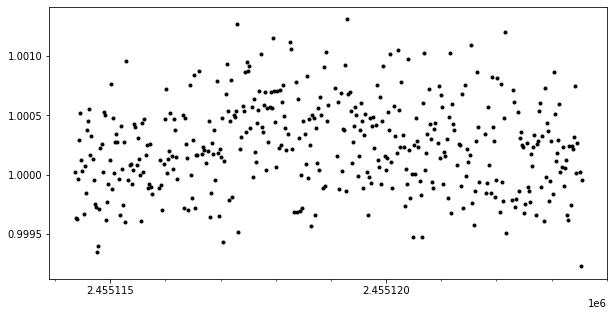

7


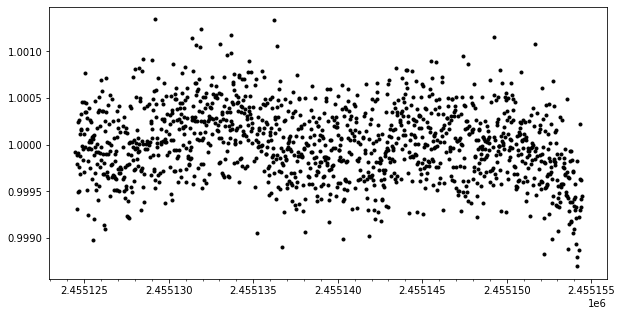

8


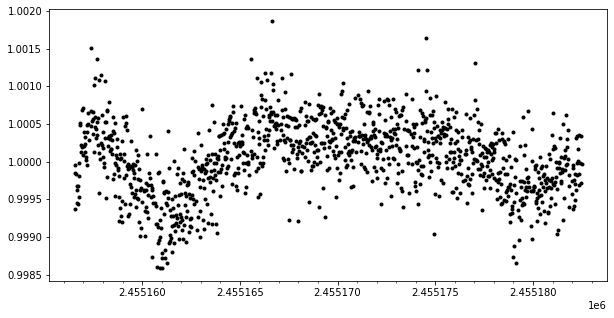

9


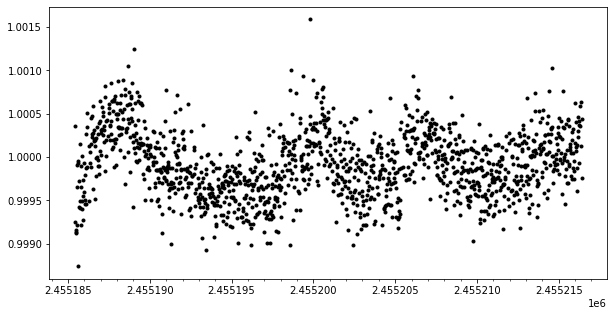

10


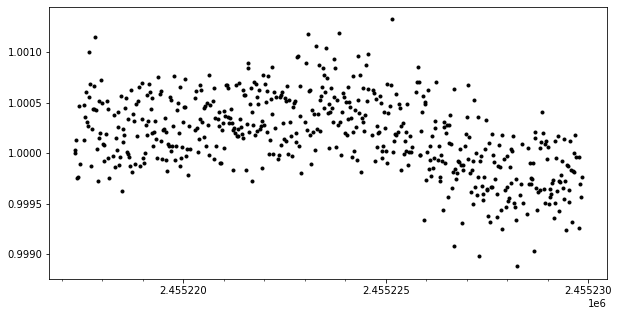

11


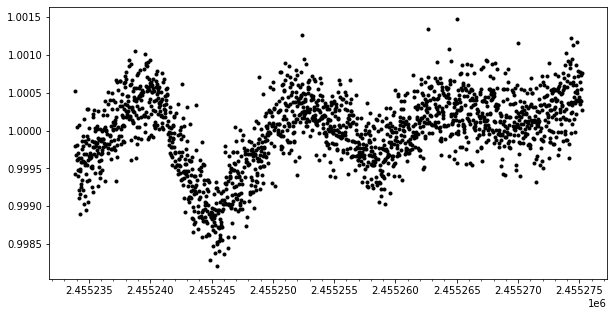

12


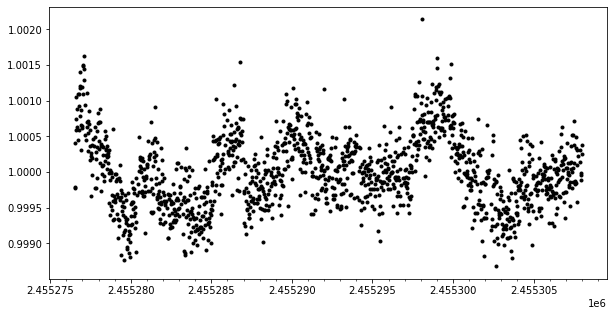

13


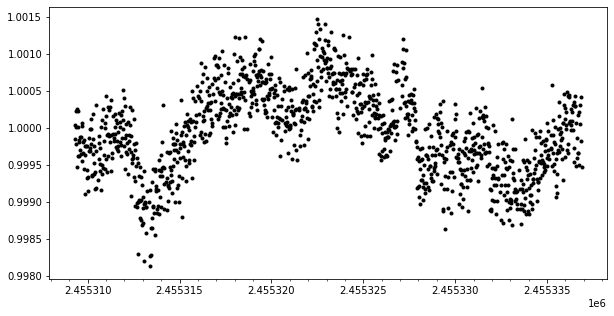

14


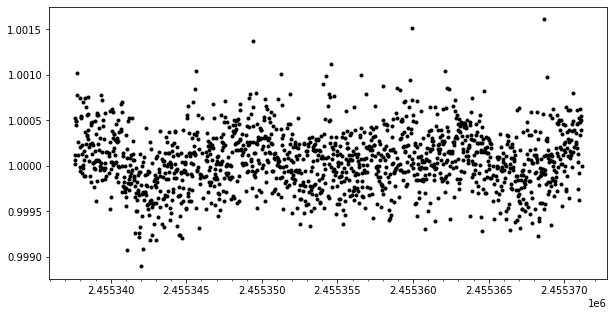

15


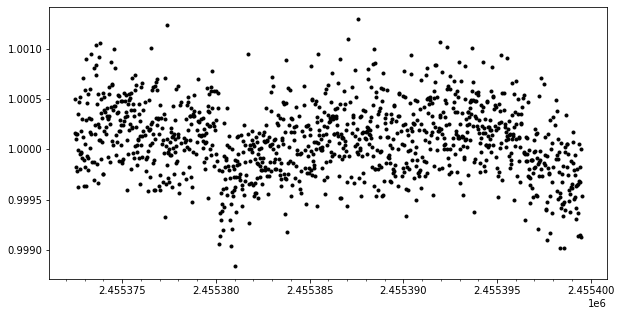

16


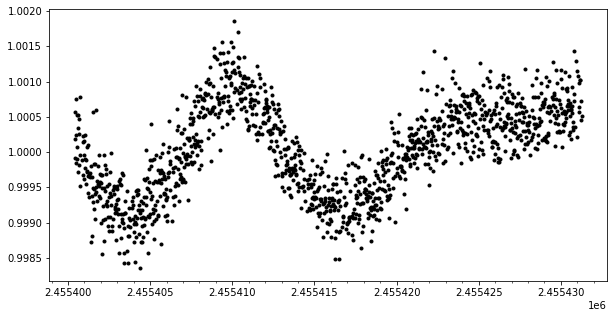

17


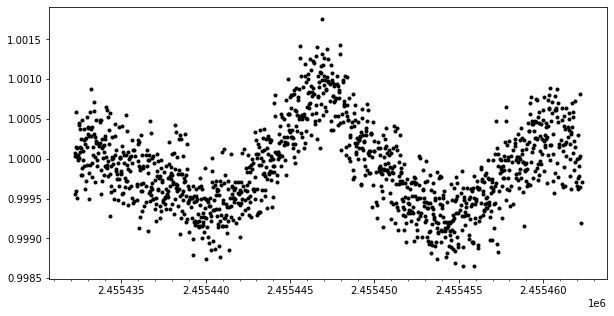

18


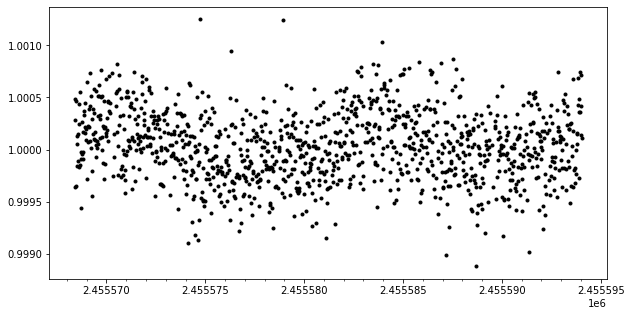

19


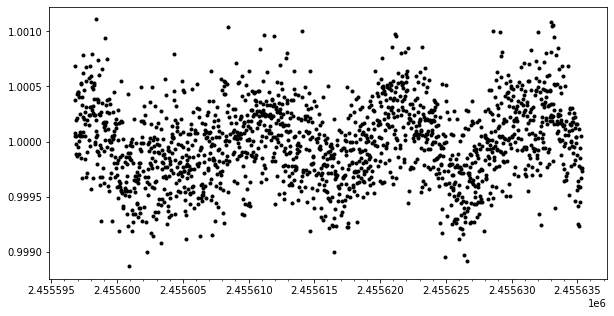

20


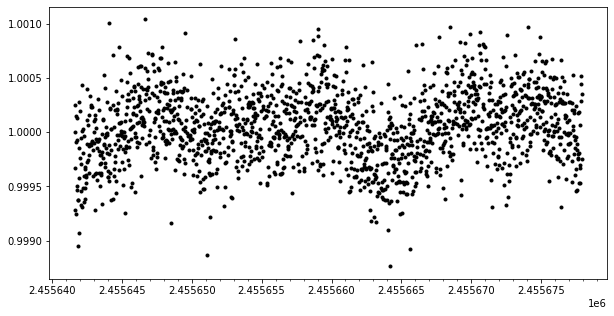

21


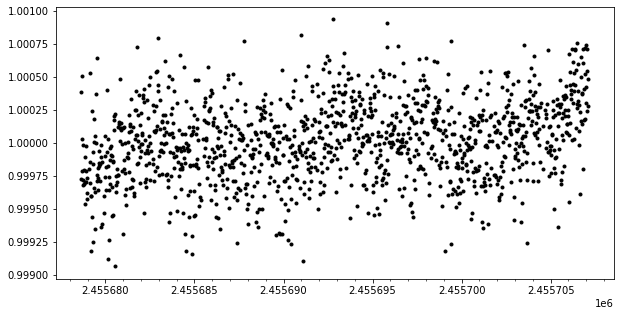

22


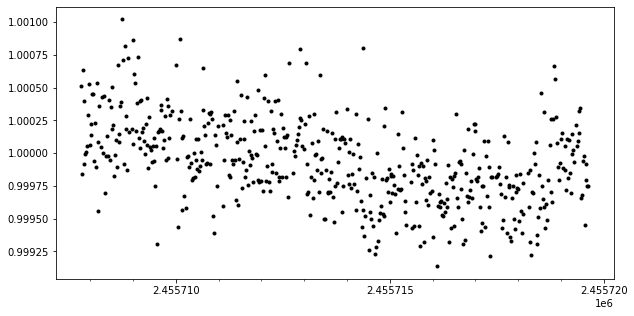

23


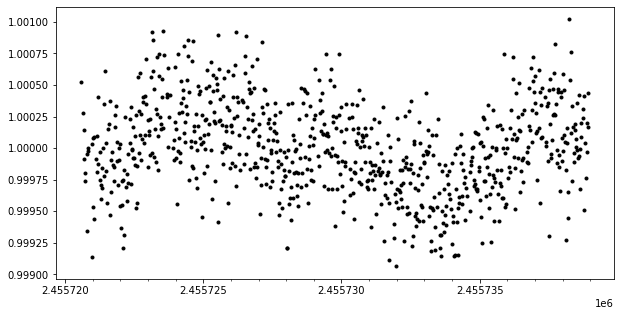

24


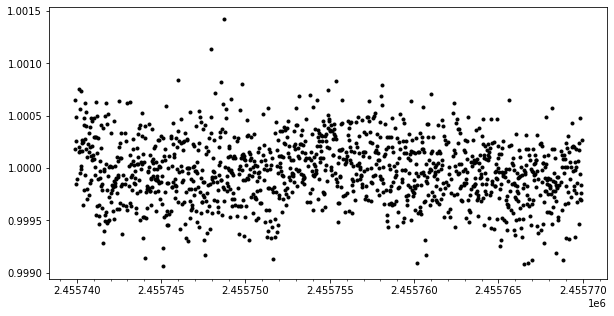

25


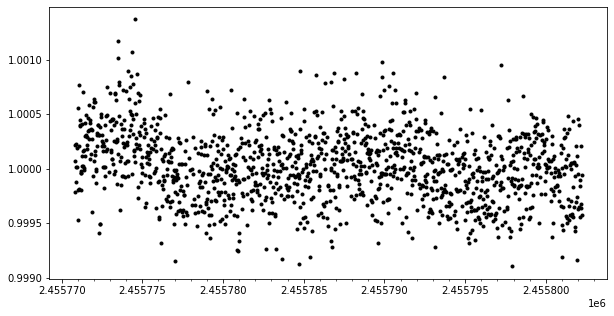

26


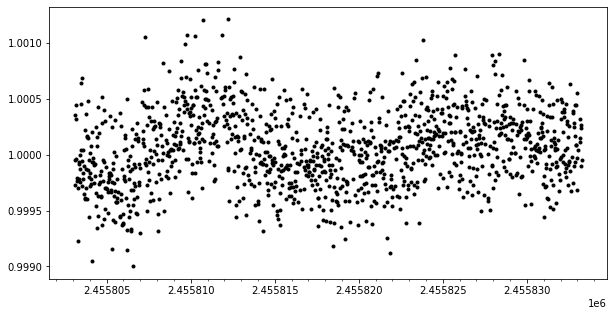

27


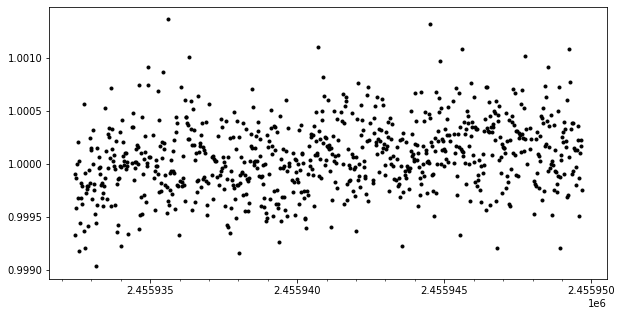

28


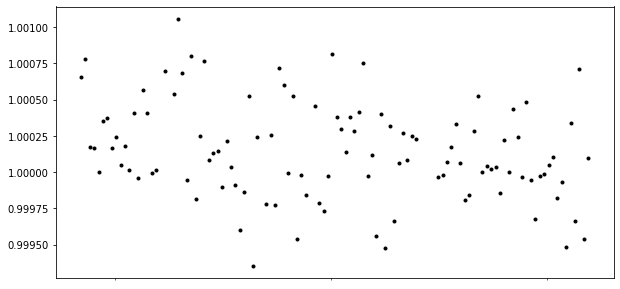

29


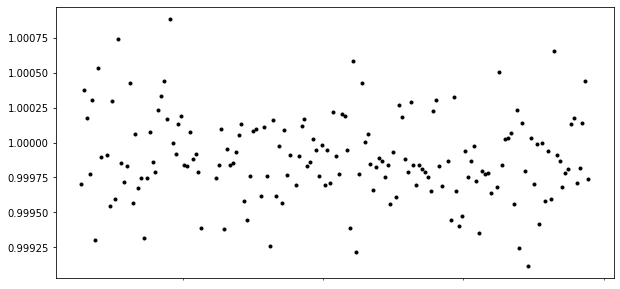

30


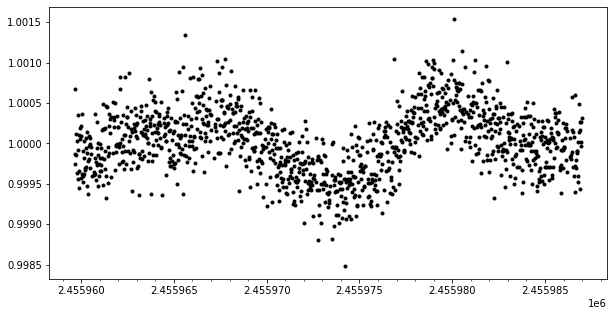

31


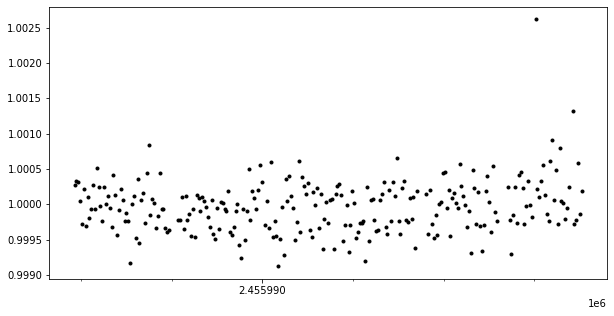

32


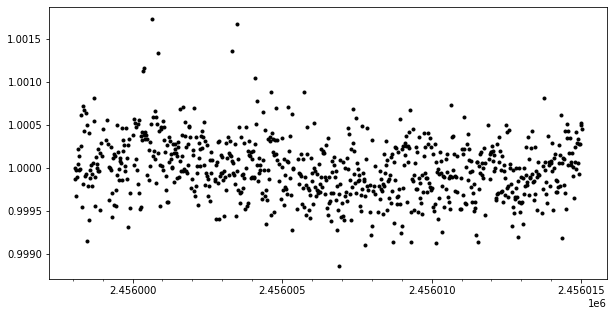

33


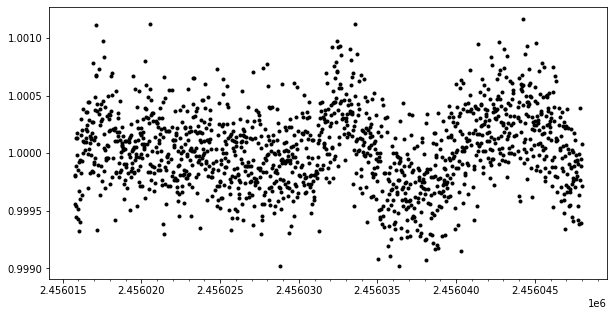

34


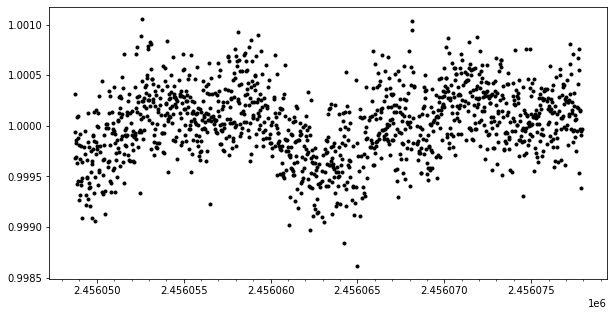

35


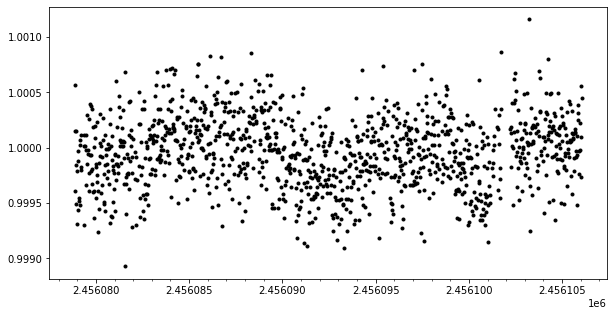

36


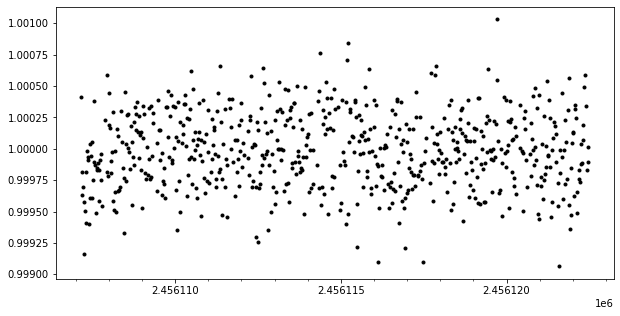

37


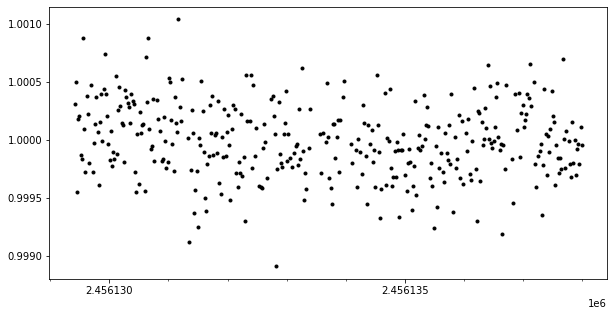

38


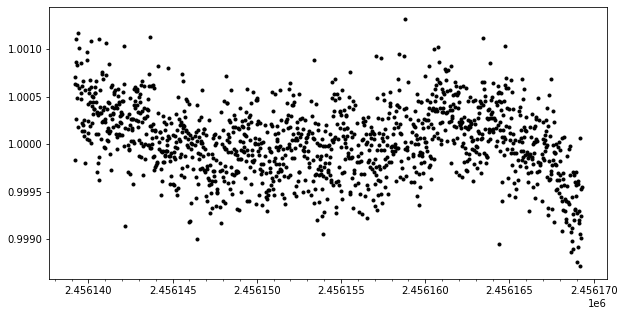

39


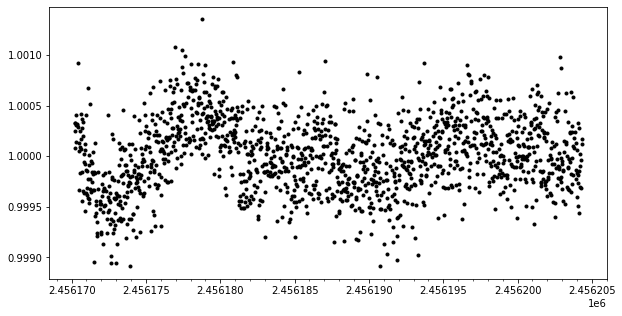

40


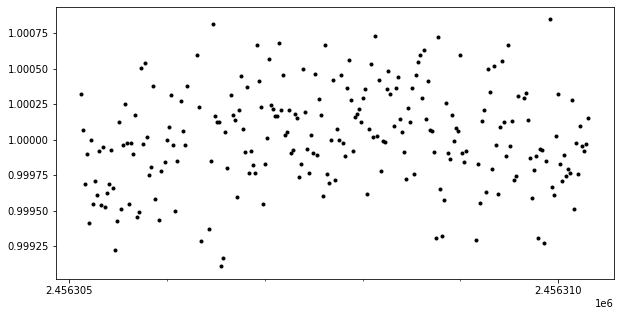

41


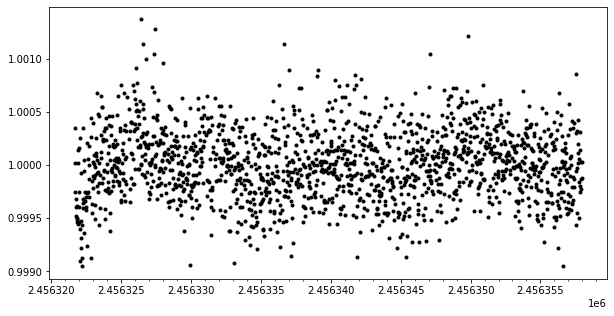

42


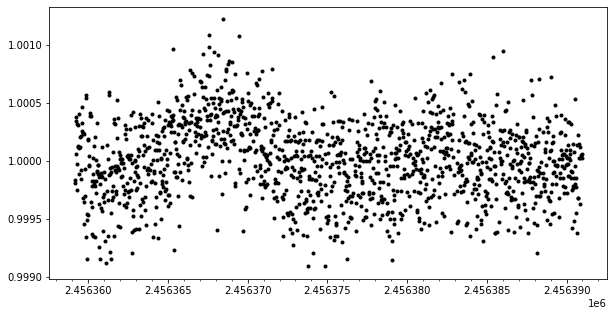

43


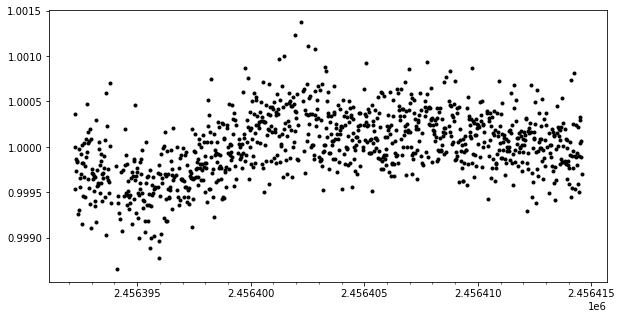

44


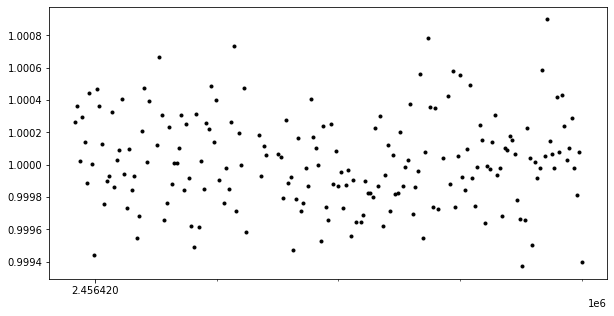

QUIT THE NOTEBOOK WHEN DONE


In [150]:
plot_q = 1
print('Data broken into ' + str(len(all_time)) + ' sections')

if plot_q:
    #%matplotlib notebook 
    #%matplotlib notebook
    %matplotlib inline
    
    print('Data broken into ' + str(len(all_flux)) + ' sections')
    ax = plt.axes()
    ax.xaxis.set_major_locator(MultipleLocator(10))
    
    for ci in np.arange(len(all_flux)):
        transit_idx_tempor =   mask_mulit_transits(all_t0_bkjd, all_period_day, duration_day=all_duration_day, 
                                      time_bkjd=all_time[ci], 
                                      flux=all_flux[ci], 
                                      lc=None, 
                                      return_index=True)
        
        print(ci)
        plt.figure(figsize = (10,5))
        ax = plt.axes()
        if len(all_time[ci]) > 1:
            ax.xaxis.set_major_locator(MultipleLocator(5))
            ax.xaxis.set_minor_locator(MultipleLocator(1))
            ax.ticklabel_format(useOffset=False)
        plt.plot(all_time[ci][~transit_idx_tempor], all_flux[ci][~transit_idx_tempor], '.k')
        #plt.plot(all_time[ci][transit_idx_tempor], all_flux[ci][transit_idx_tempor], color = [1,1,1,.0], linestyle='', marker='.')
        plt.show(block = False)
        #plt.pause(.3)

all_time0, all_flux0 = np.copy(all_time), np.copy(all_flux)
print("QUIT THE NOTEBOOK WHEN DONE")

# STOP HERE AND CHECK IF YOU REALLY WANT TO MANUALLY SPLIT/SPLICE

In [151]:
split_numbers = [2455127 ]
#manual_split([x,y,z,...]): input must be an **array**, can put a one element array, splits into two sections 
#manual_splice(start,end): crops out section in between
#delete_section(section_num): deletes entire section

#manual_split([2455079.5,2455073.5,2456225])
#manual_split([2455079.5])
#if len(split_numbers) > 0:
#    manual_split(split_numbers)
#manual_splice(2455926.5,2455927.5)
#manual_split([2456327.5])
#manual_splice(2455834,2455835.5 )
#manual_splice(2455863,2455865)
#delete_section()
#if you splice, dont go back and run any cells before this, otherwise the splices get wiped

Data broken into 45 sections
Data broken into 45 sections
0


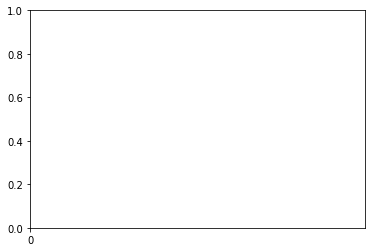

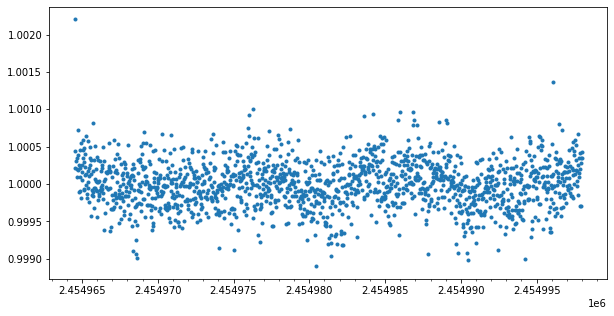

1


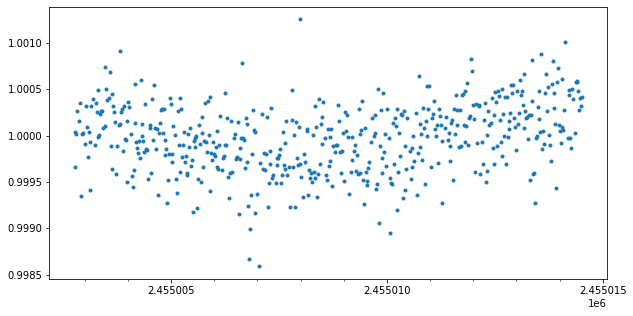

2


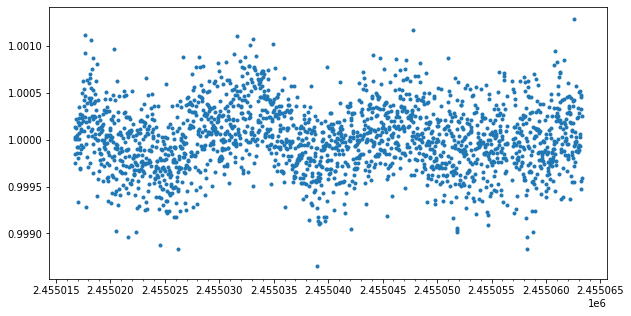

3


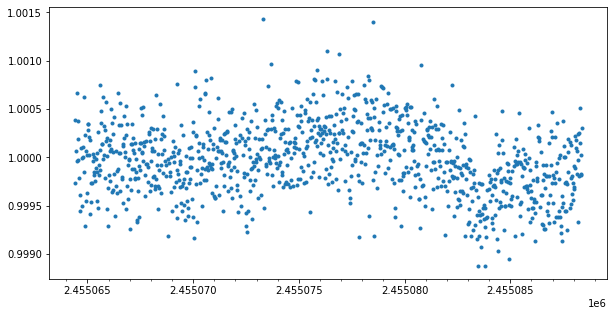

4


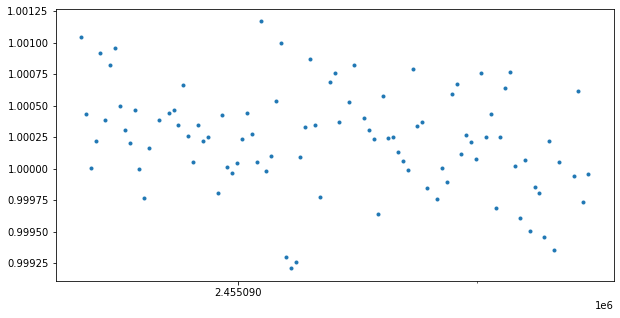

5


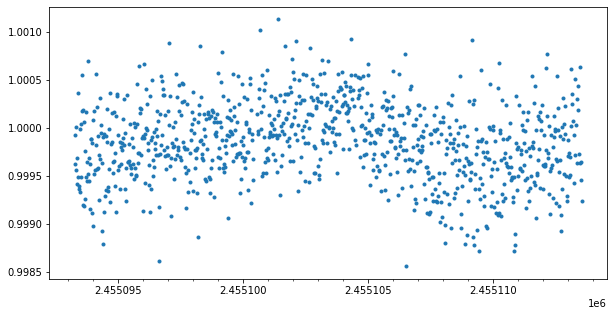

6


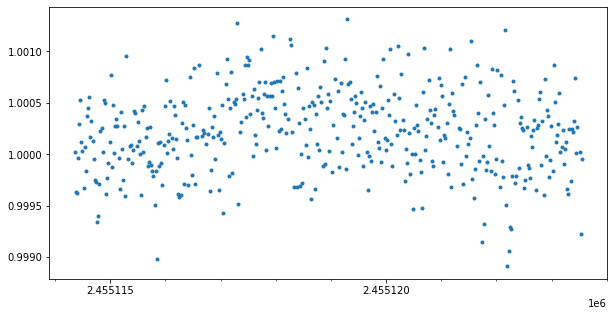

7


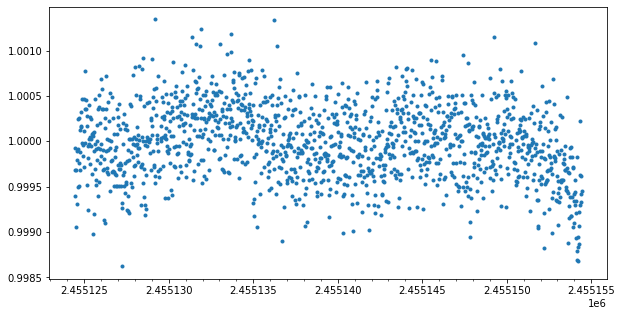

8


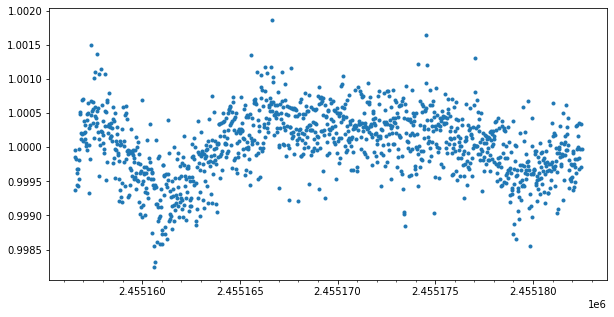

9


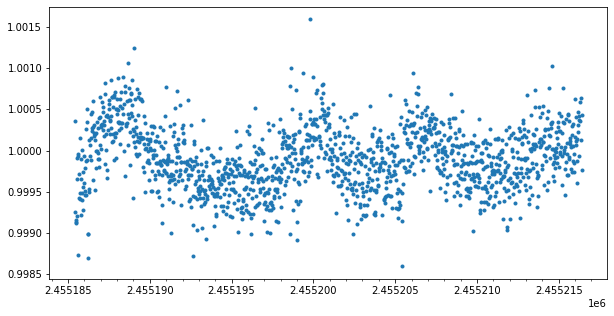

10


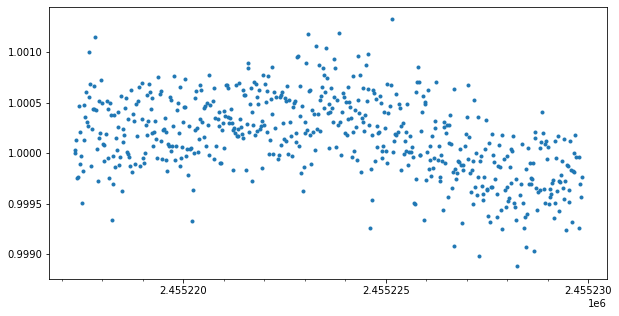

11


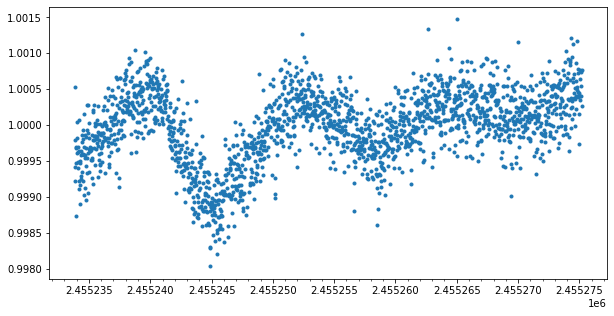

12


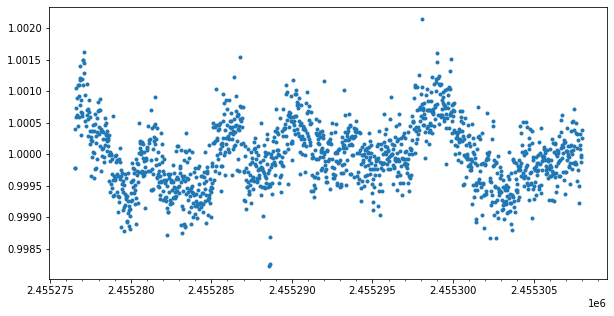

13


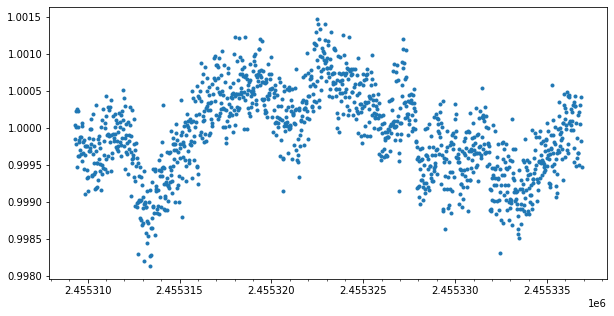

14


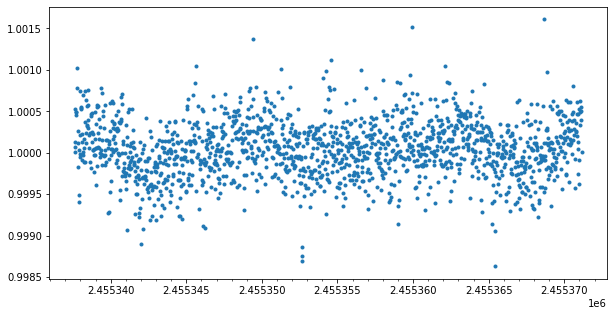

15


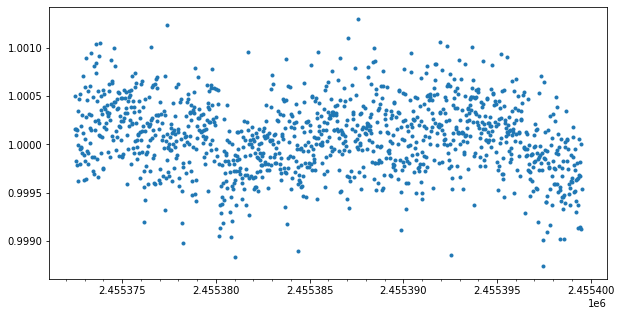

16


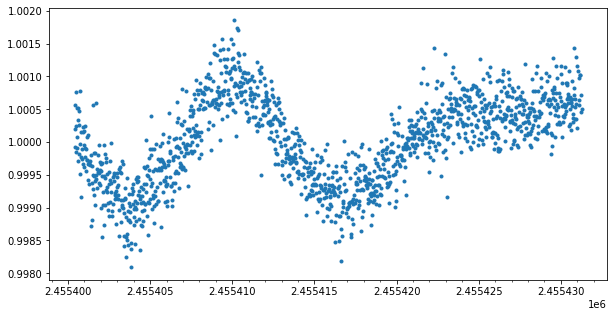

17


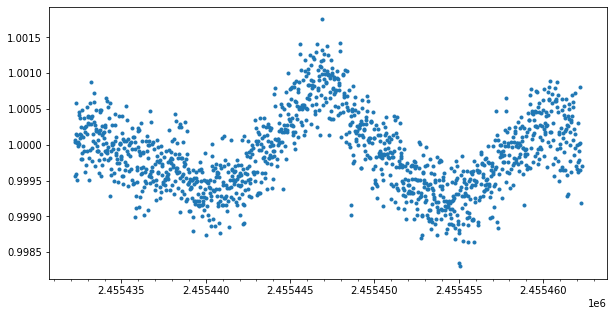

18


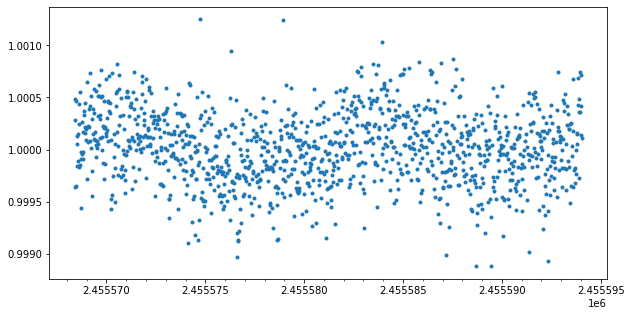

19


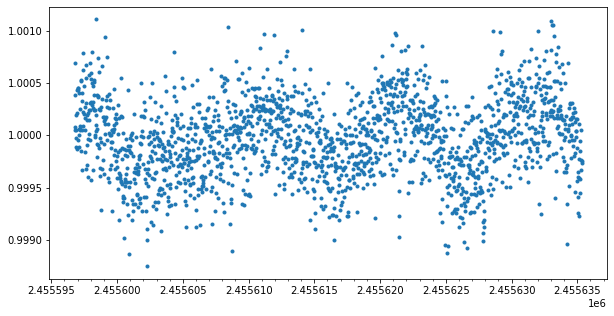

20


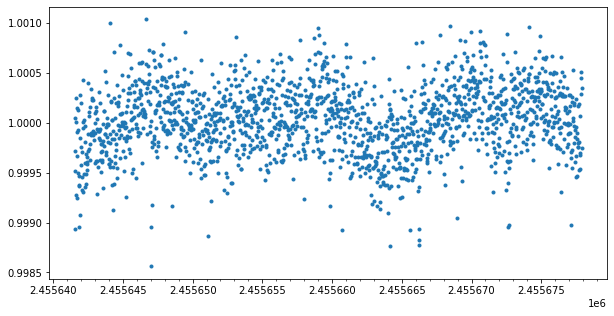

21


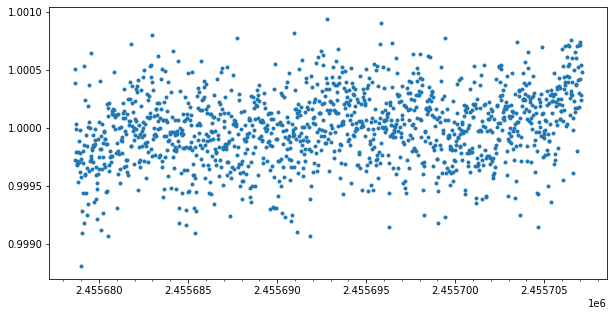

22


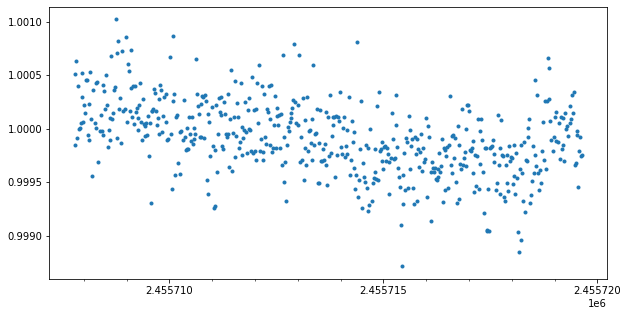

23


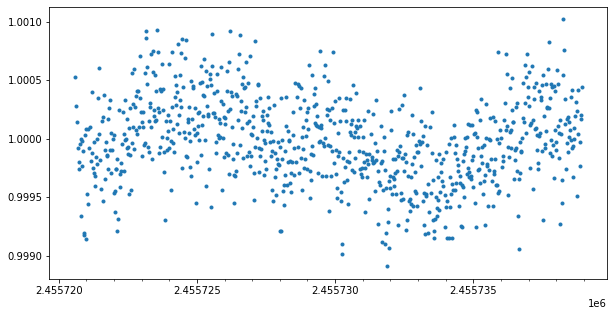

24


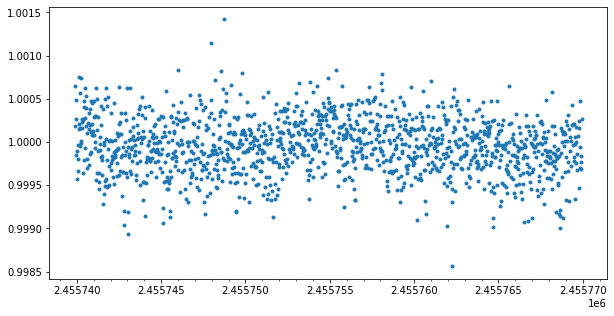

25


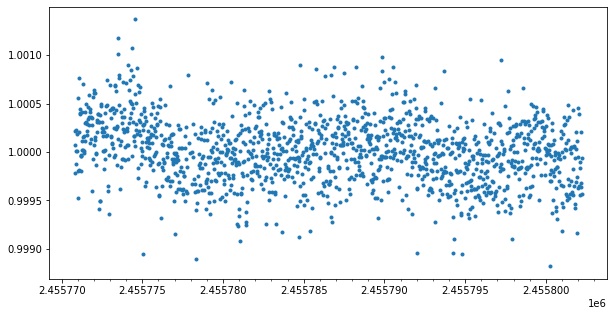

26


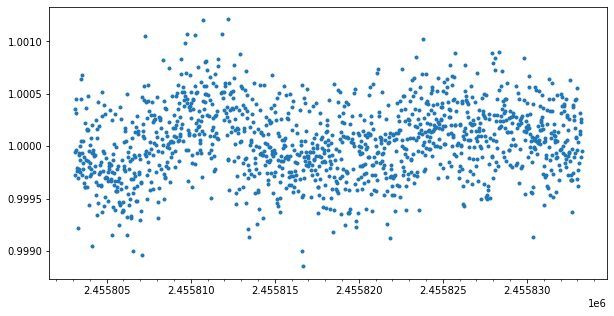

27


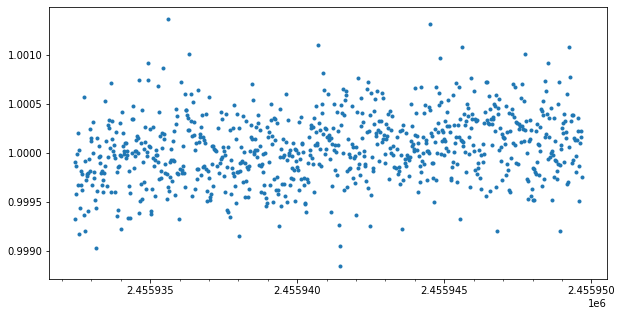

28


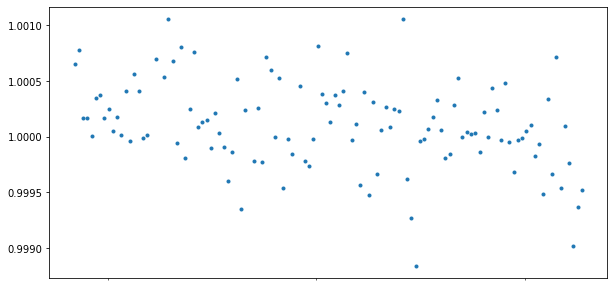

29


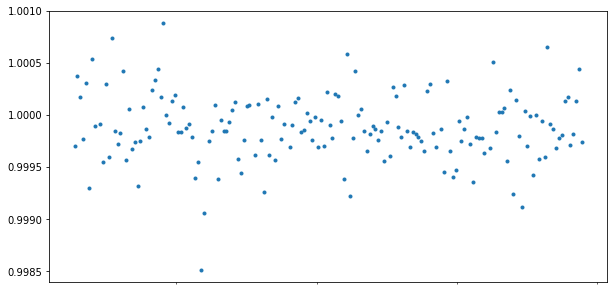

30


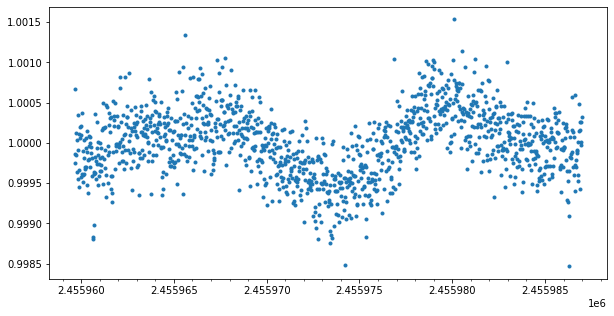

31


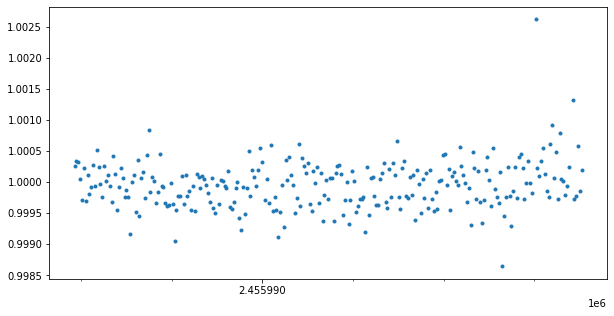

32


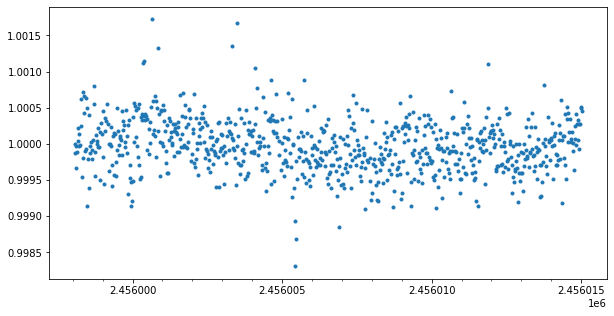

33


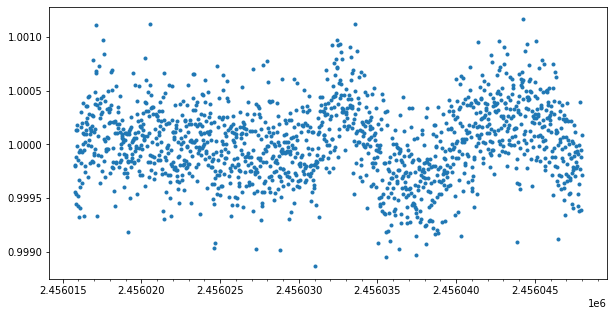

34


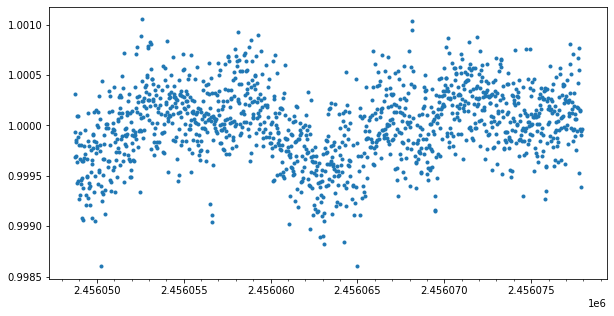

35


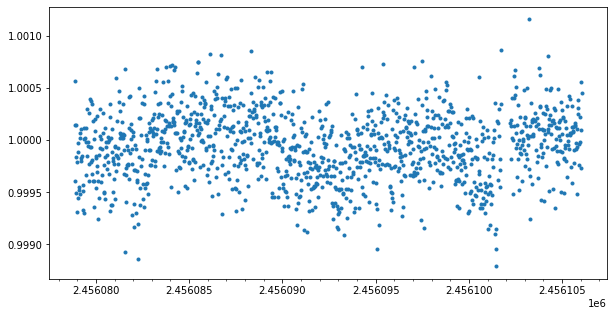

36


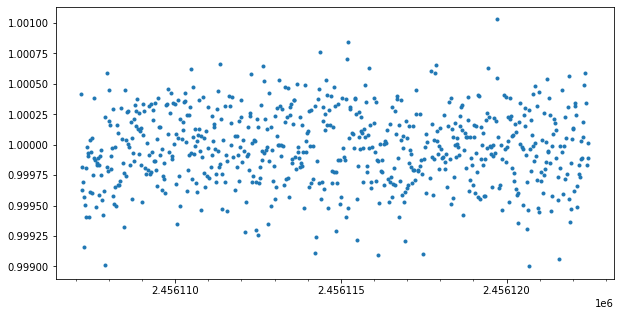

37


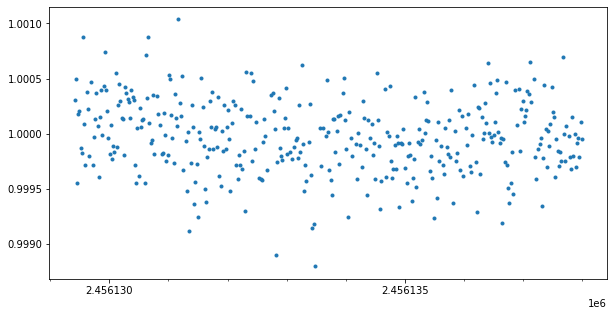

38


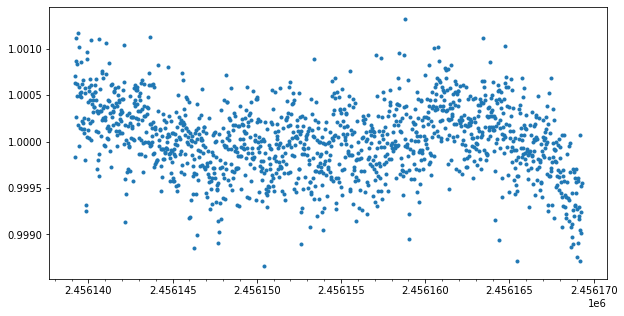

39


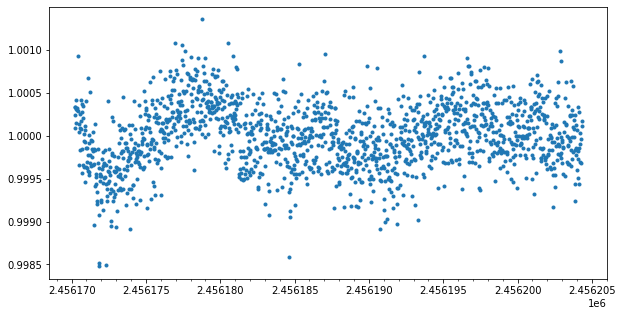

40


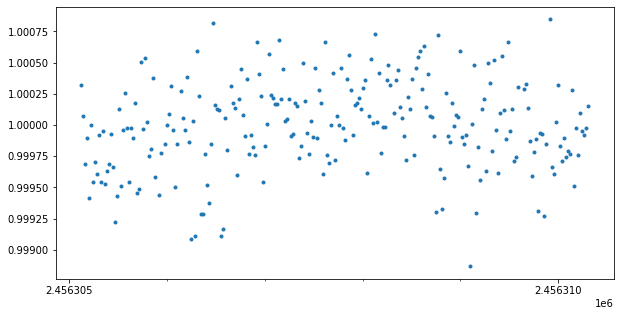

41


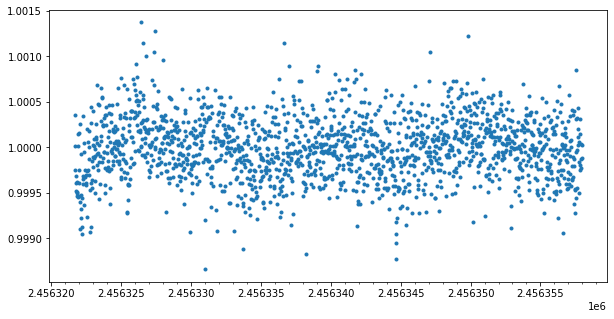

42


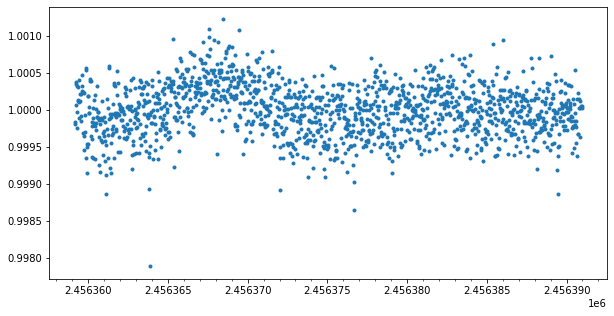

43


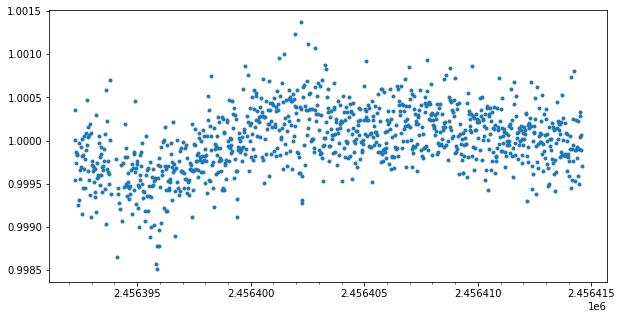

44


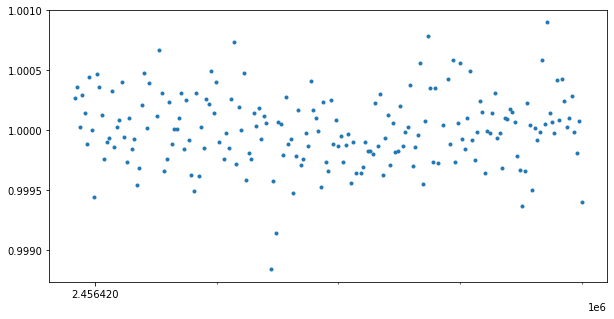

QUIT THE NOTEBOOK WHEN DONE


In [152]:
#you can skip this if you didnt splice manually, it just checks
plot_q = 1
print('Data broken into ' + str(len(all_time)) + ' sections')

if plot_q:
    #%matplotlib notebook 
    #%matplotlib notebook
    %matplotlib inline
    print('Data broken into ' + str(len(all_time)) + ' sections')
    ax = plt.axes()
    ax.xaxis.set_major_locator(MultipleLocator(10))
    
    for ci in np.arange(len(all_flux)):
        print(ci)
        plt.figure(figsize = (10,5))
        ax = plt.axes()
        if len(all_time[ci]) > 1:
            ax.xaxis.set_major_locator(MultipleLocator(5))
            ax.xaxis.set_minor_locator(MultipleLocator(1))
            ax.ticklabel_format(useOffset=False)
        plt.plot(all_time[ci], all_flux[ci], '.')
        plt.show(block = False)
    #plt.pause(1.0)

all_time0, all_flux0 = np.copy(all_time), np.copy(all_flux)
print("QUIT THE NOTEBOOK WHEN DONE")

In [153]:
# Cut sections that are lest than 50 points long
cnt = np.array([len(all_time[i]) for i in range(len(all_time))])

gi = cnt > 40

all_time0, all_flux0 = np.copy(all_time), np.copy(all_flux)

all_time, all_flux = [], []
for i in np.arange(len(all_time0)):
    
    transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, duration_day=all_duration_day, 
                                      time_bkjd=all_time0[i], 
                                      flux=all_flux0[i], 
                                      lc=None, 
                                      return_index=True)
    
    gi = len(all_time0[i][~transit_idx]) > 40

    if gi:
        all_time.append(all_time0[i])
        all_flux.append(all_flux0[i])
        
    else:
        print('Filtered section', i)

In [154]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from scipy.optimize import minimize_scalar

smo_h, lsq_h, c1_h, c2_h = [], [], [], []



# SPLINE FITTING

THE SMOOTHING BOUND IS [0.0, 0.99] IS THIS DESIRED?
THE PARTICULAR SMOOTHING BOUND IS [] IS THIS DESIRED?
[2455127]
[1207, 10554999]
0
0.12598160890838075


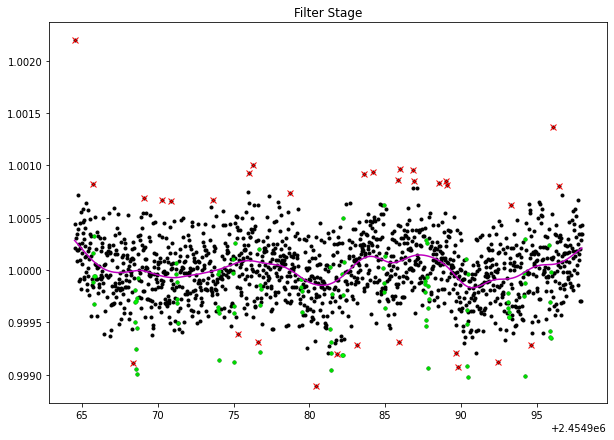

1
0.053236658944766056


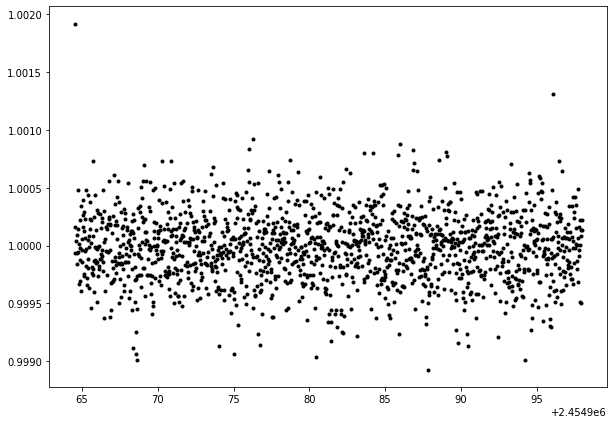

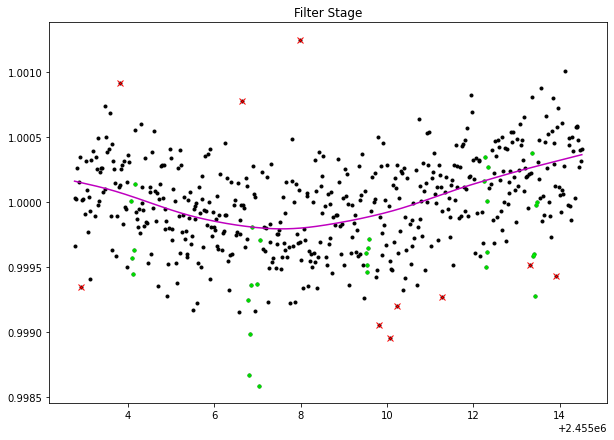

2
0.1087438679273321


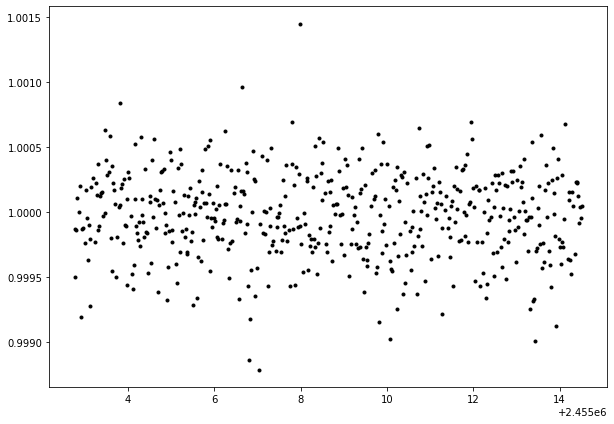

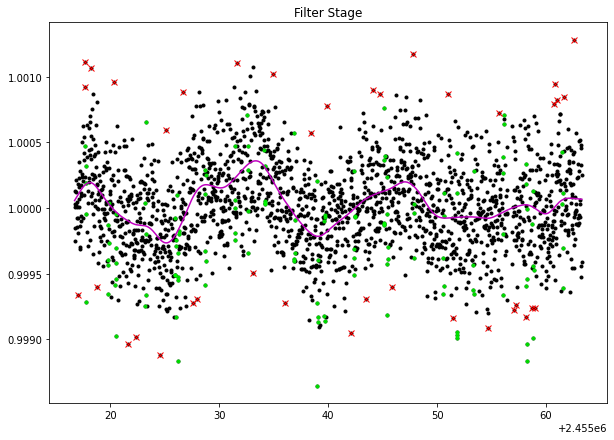

3
0.06214540040428495


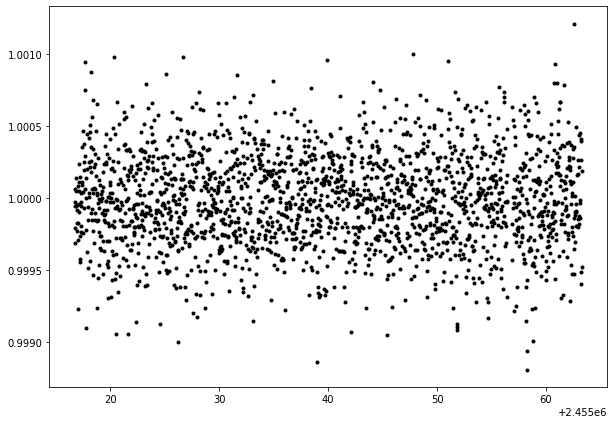

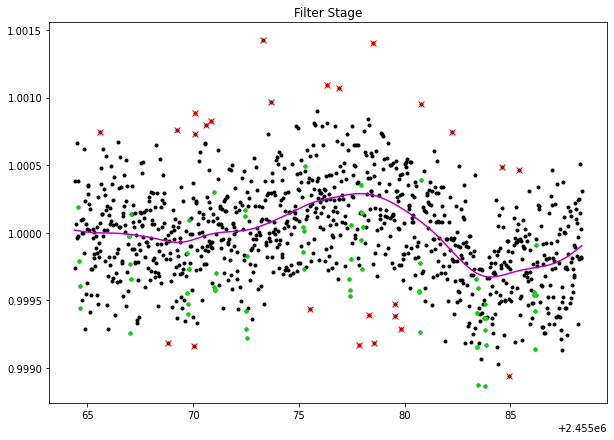

4
4.43012845326773e-08


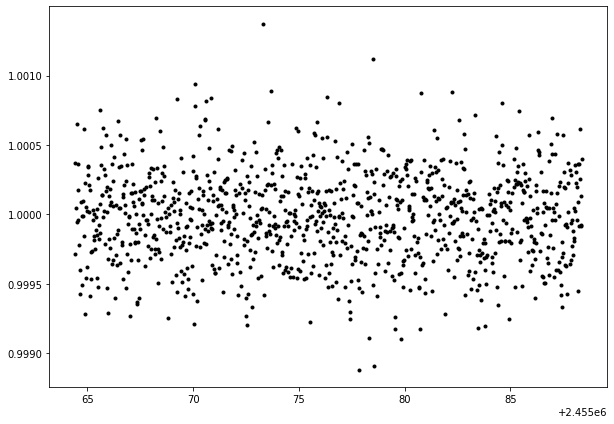

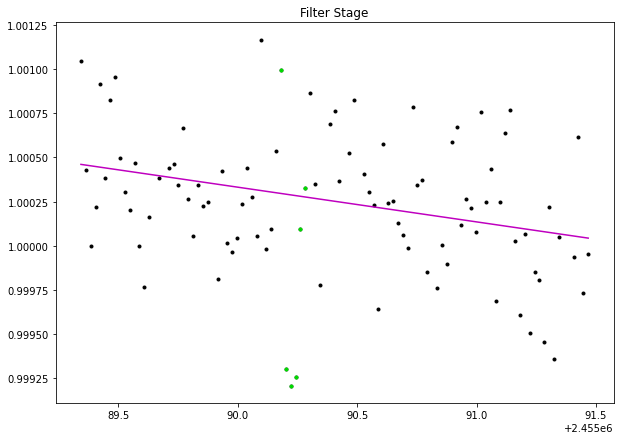

5
0.050515724376388196


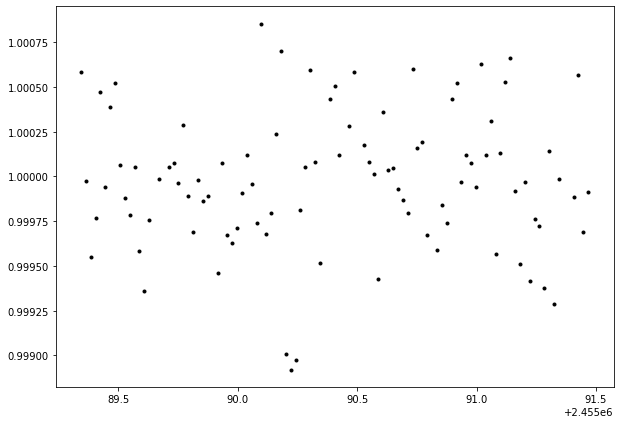

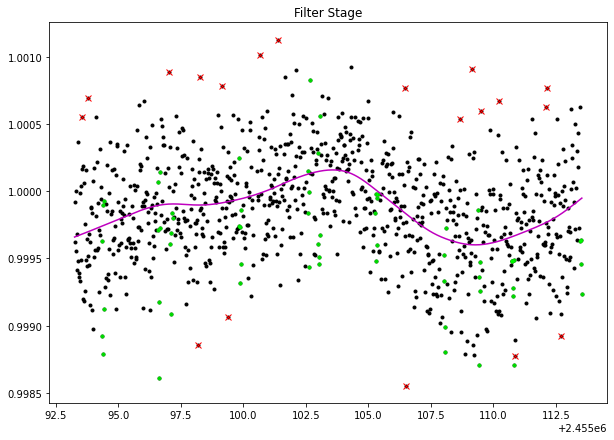

6
0.1889414467946235


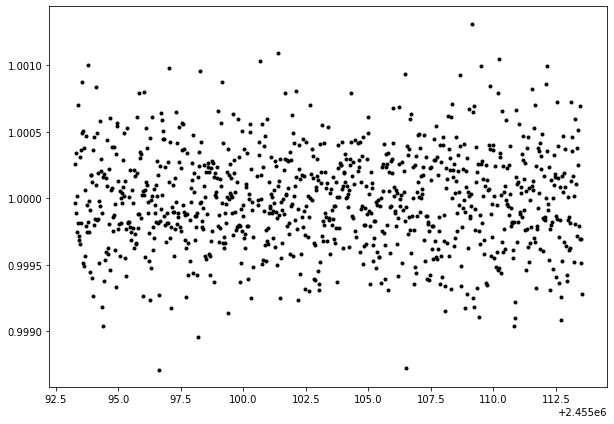

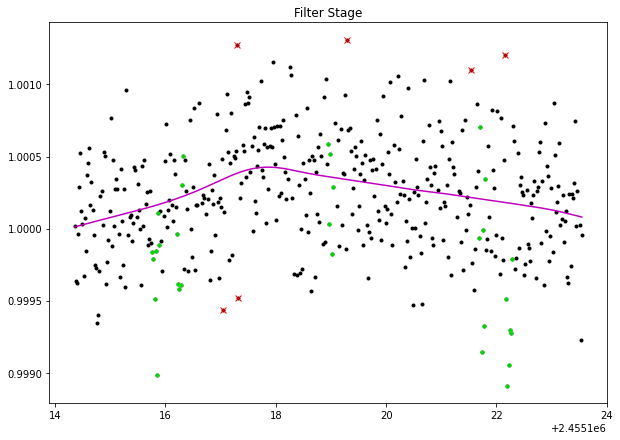

7
0.10226651069420438


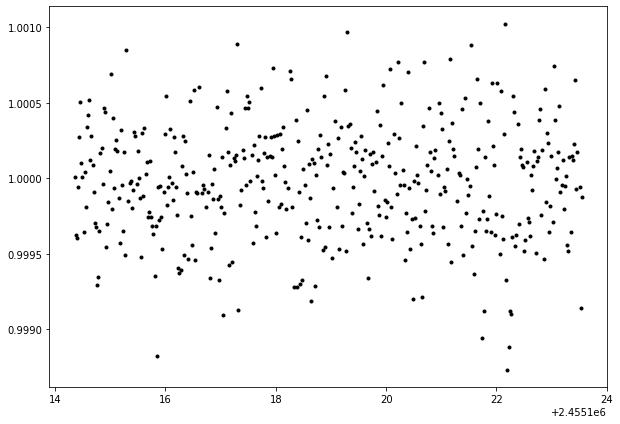

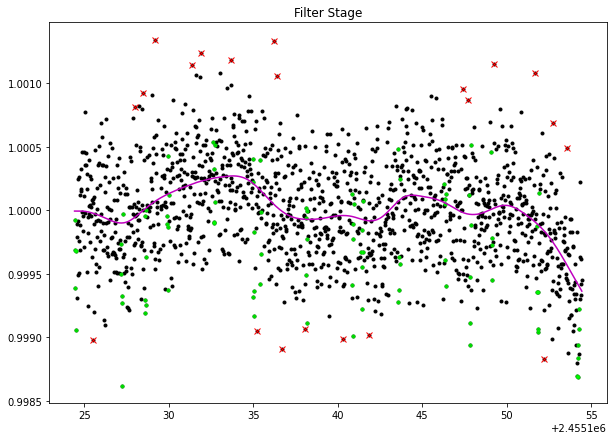

8
0.1135403412657277


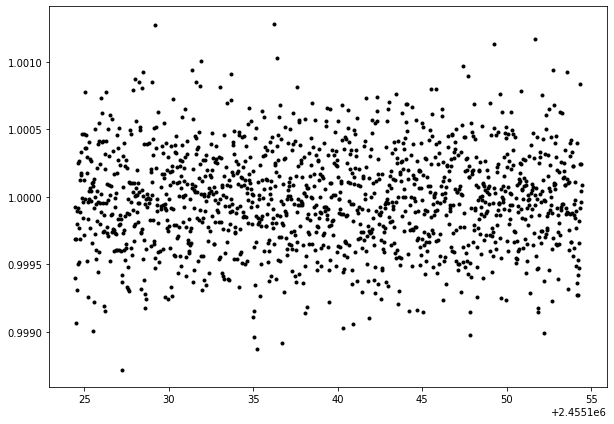

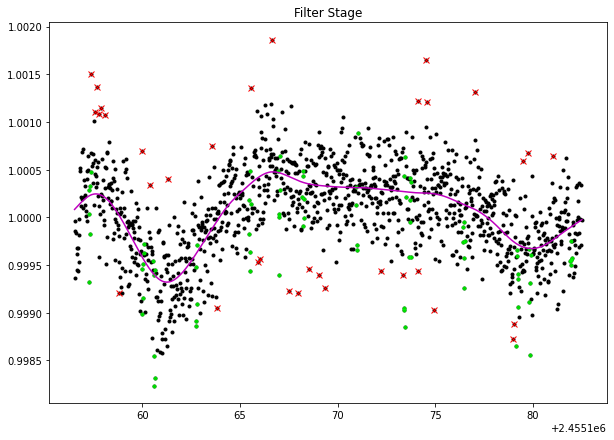

9
0.1995651450736382


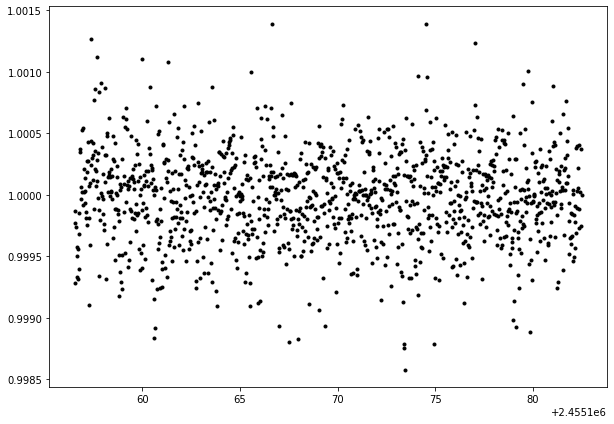

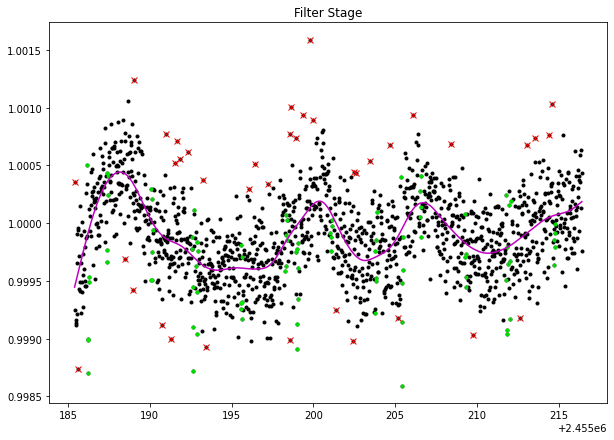

10
0.08435891232933238


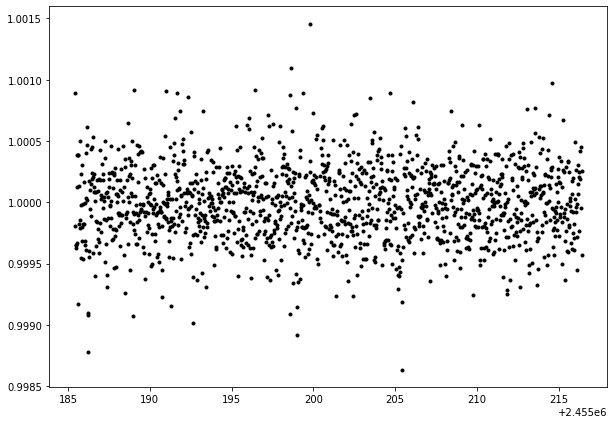

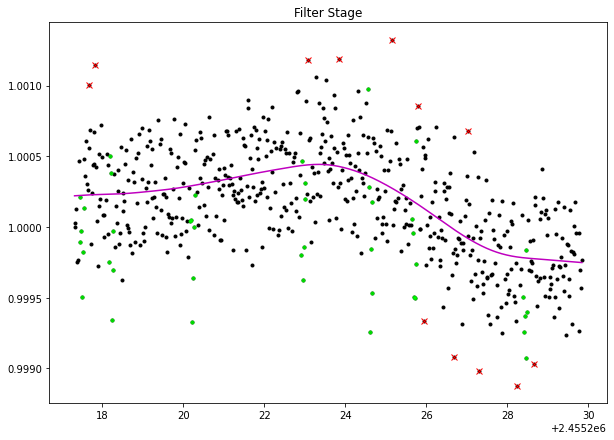

11
0.09670743159569563


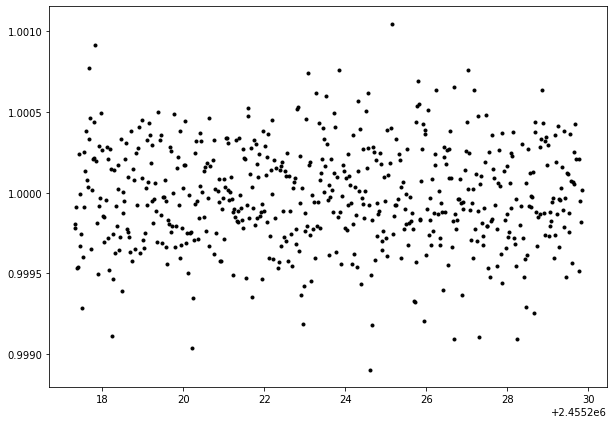

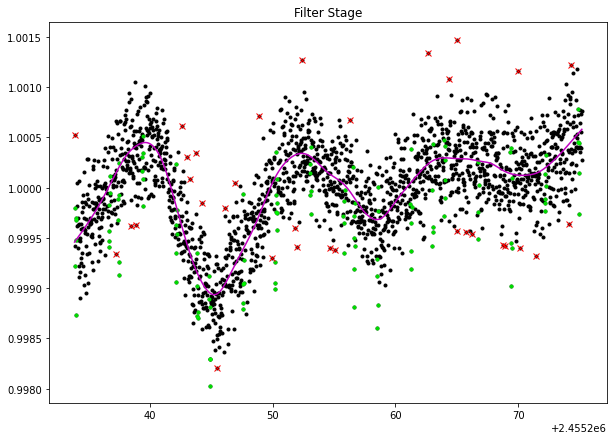

12
0.32570606732302304


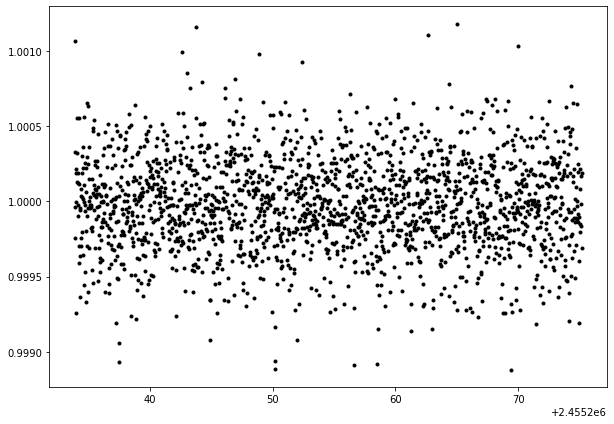

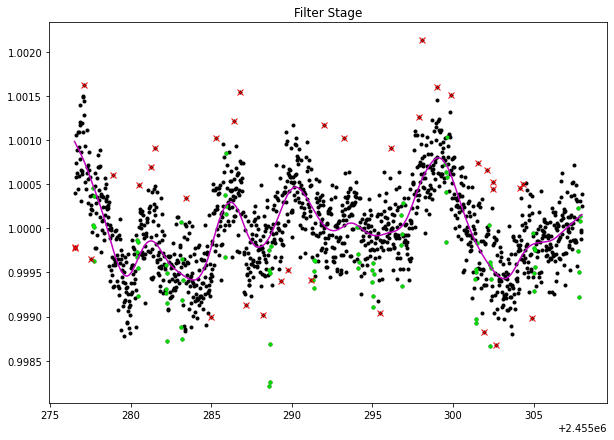

13
0.2303860013669113


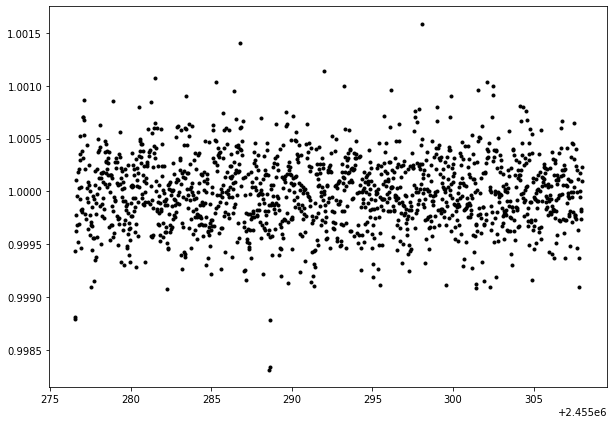

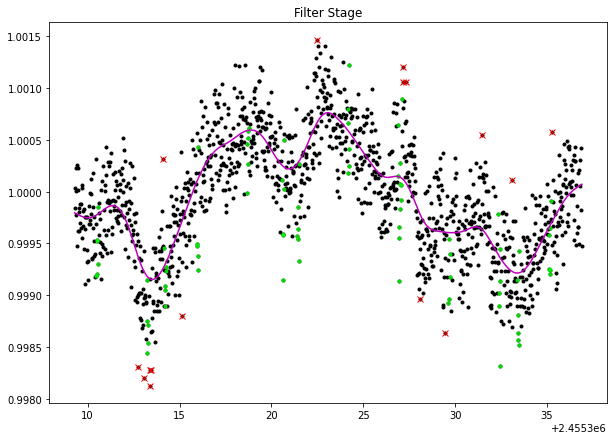

14
0.11938808135233664


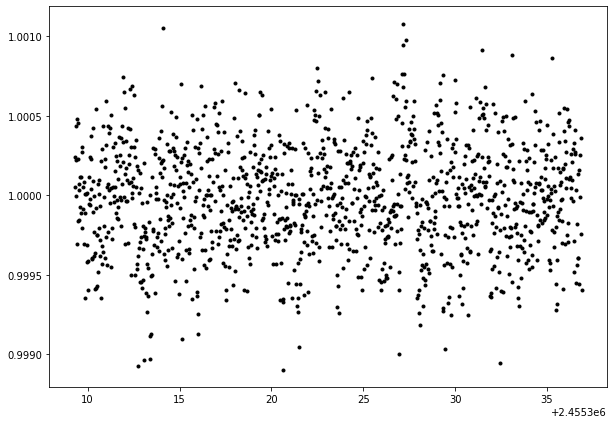

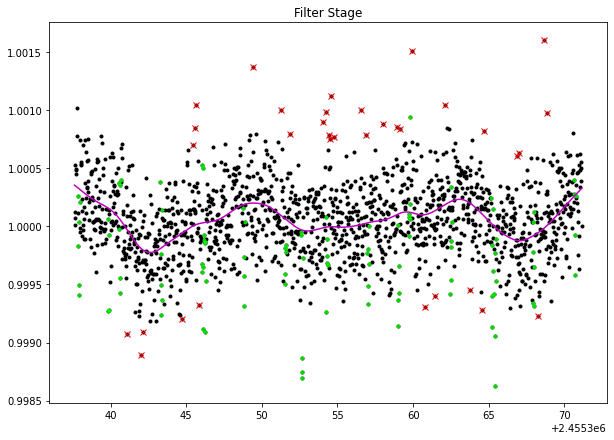

15
0.08531928444559775


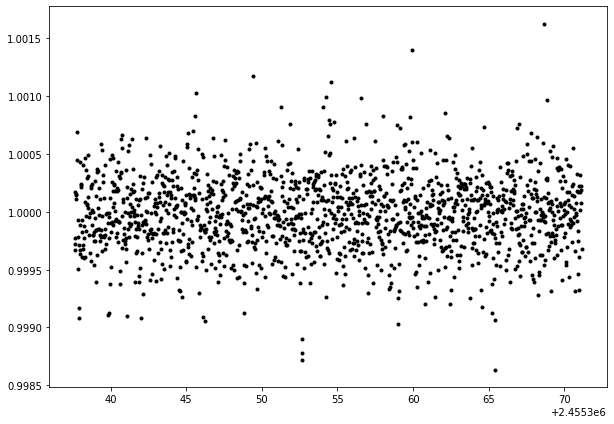

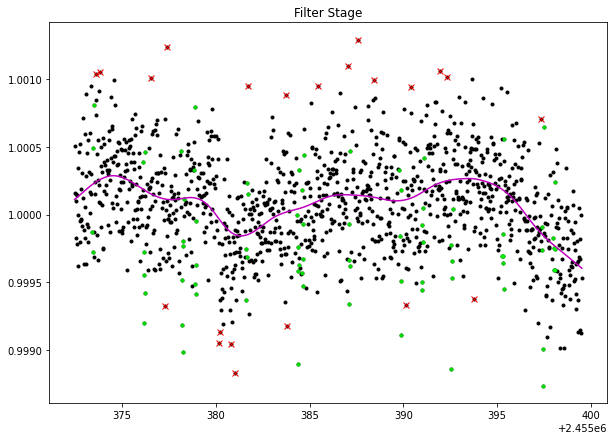

16
0.11598565379590996


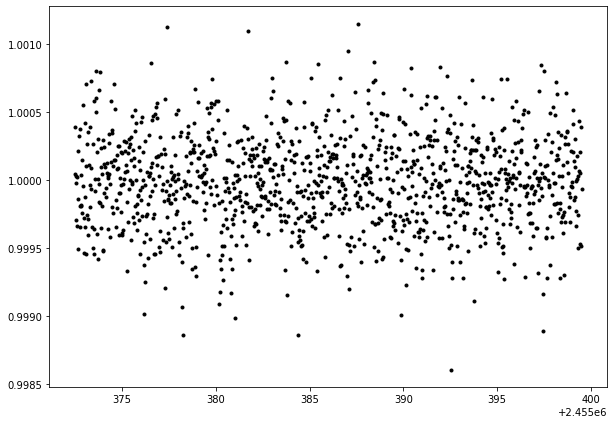

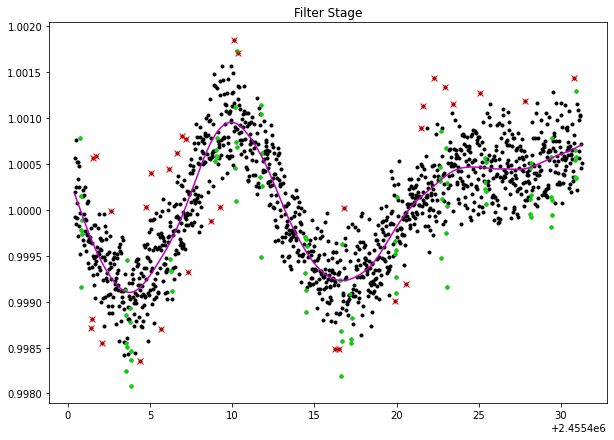

17
0.10304233025639849


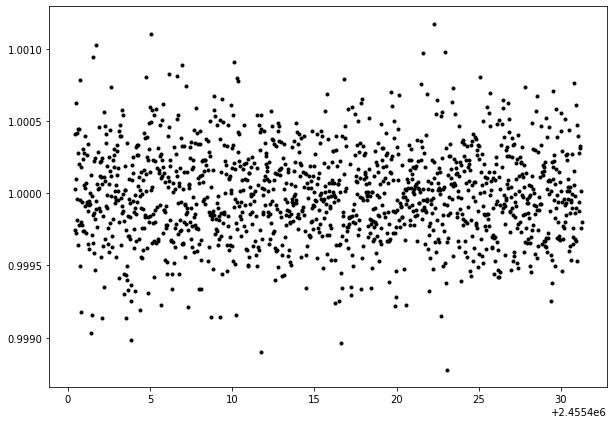

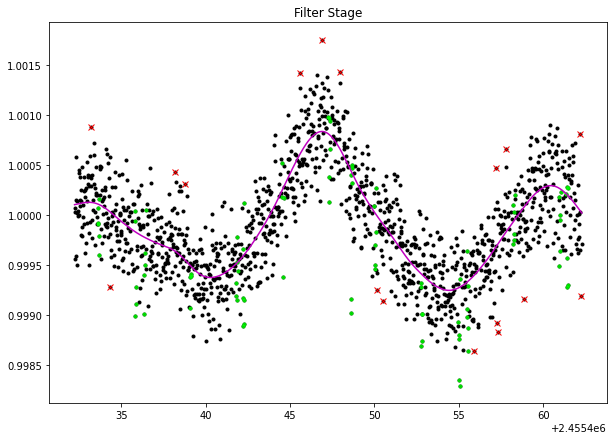

18
0.03798181589165165


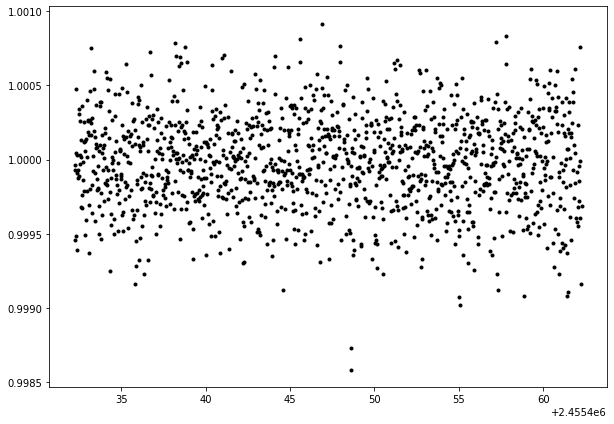

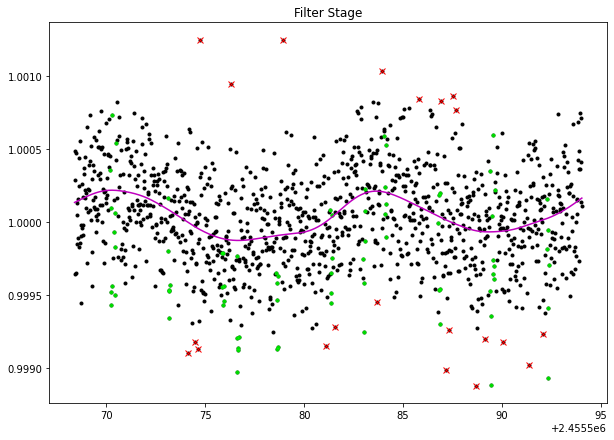

19
0.07352883988649098


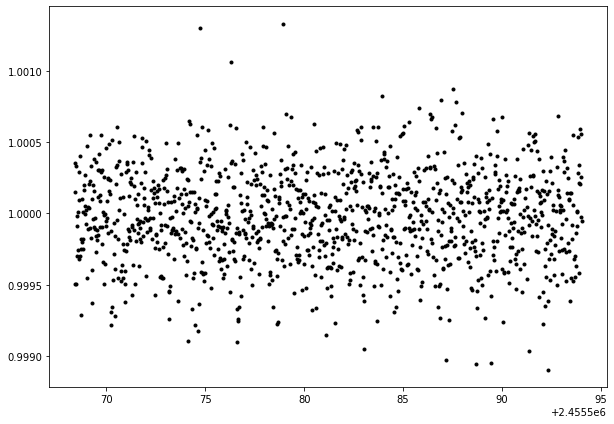

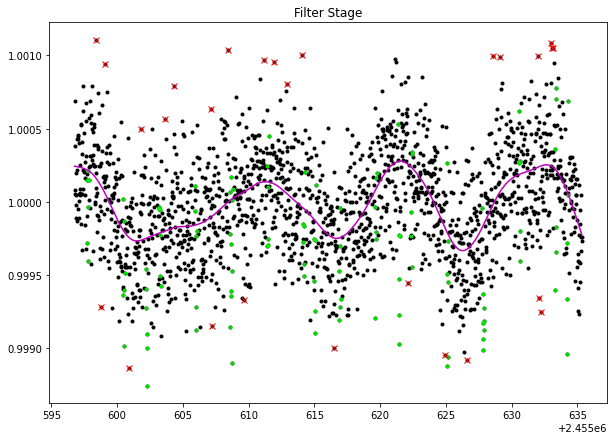

20
0.0767545393522159


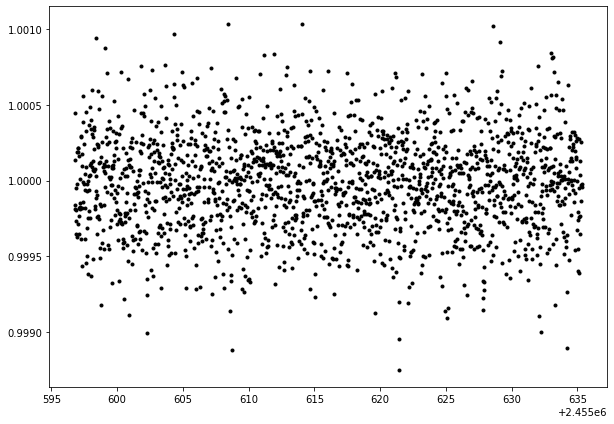

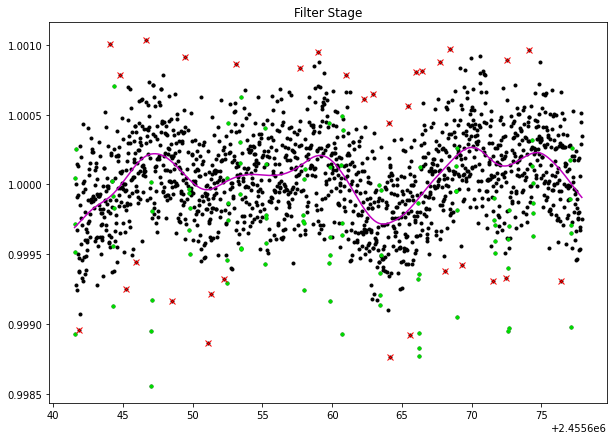

21
0.09021391902449143


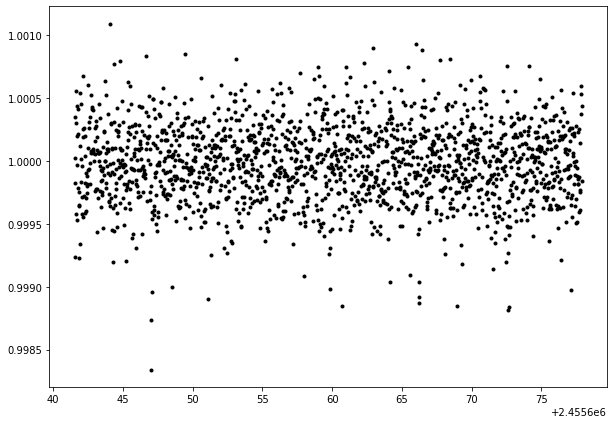

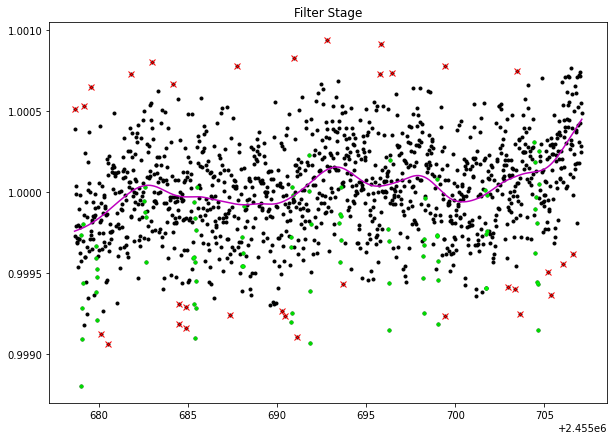

22
0.0897087013745253


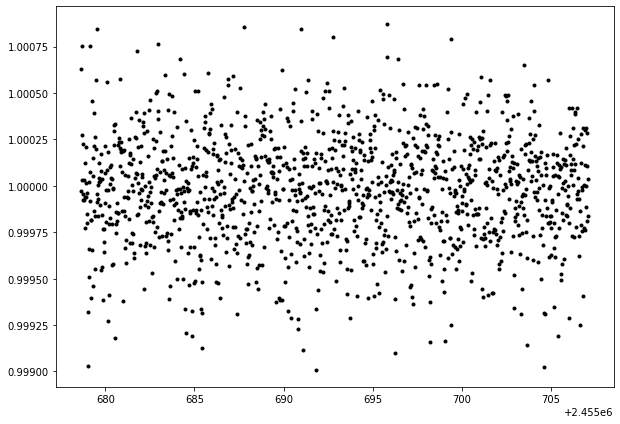

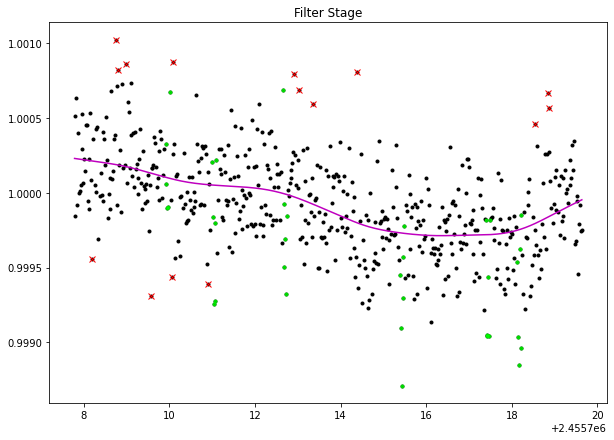

23
0.14121679737764634


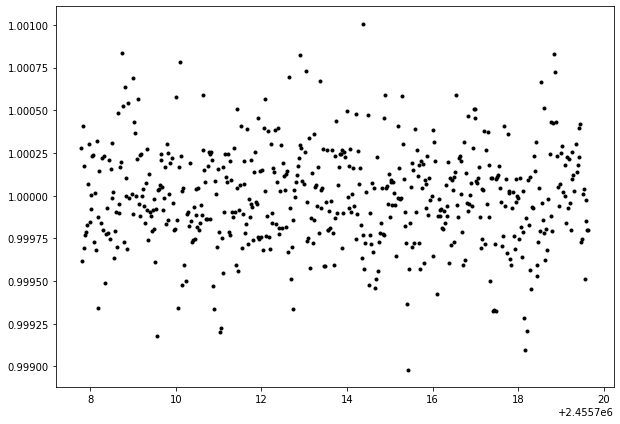

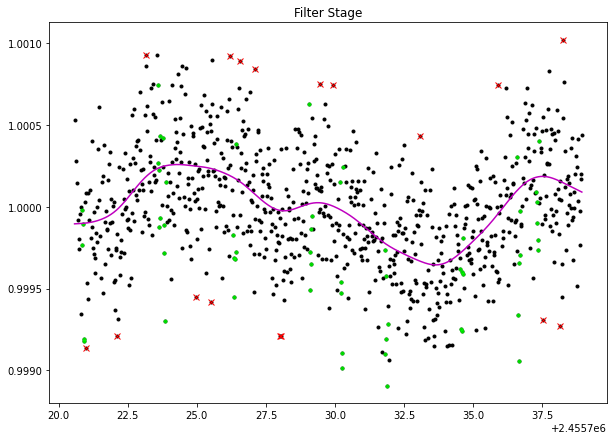

24
0.09025410987261426


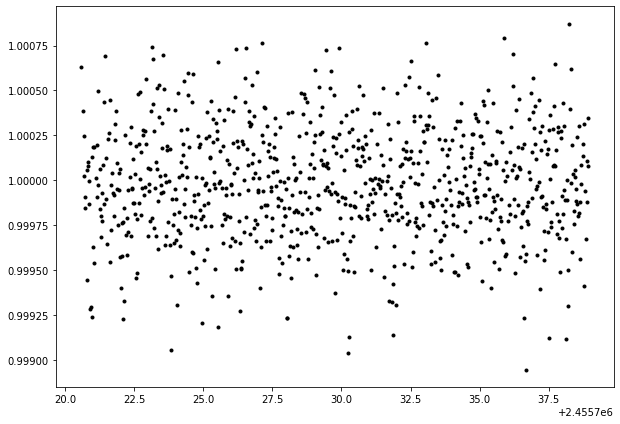

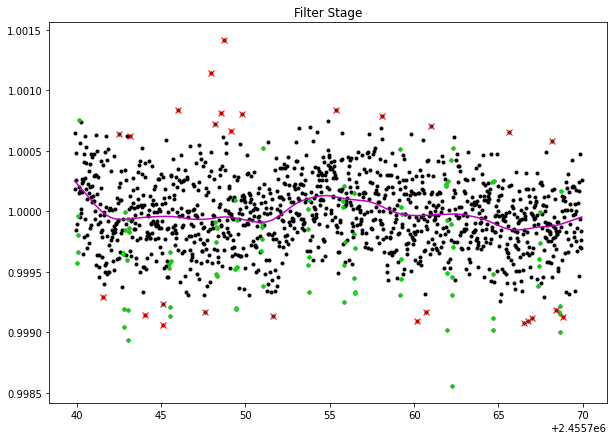

25
0.08921416218317157


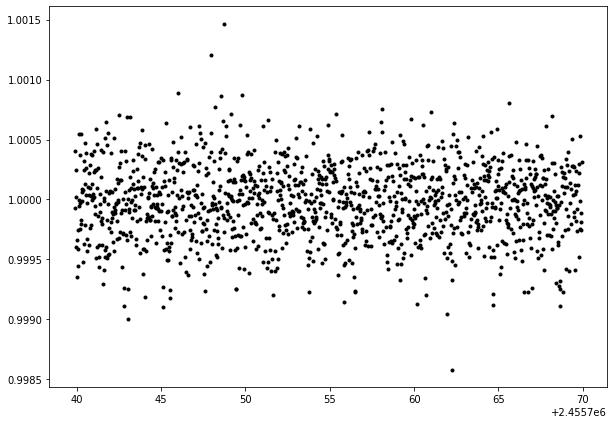

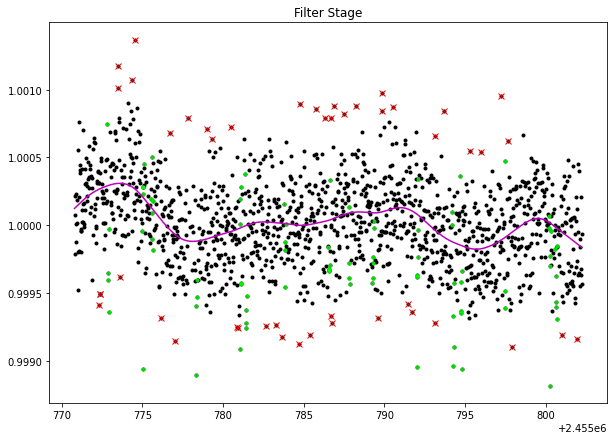

26
0.1140822150736388


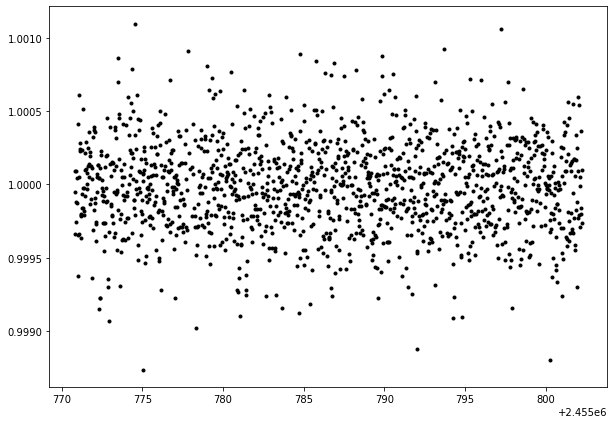

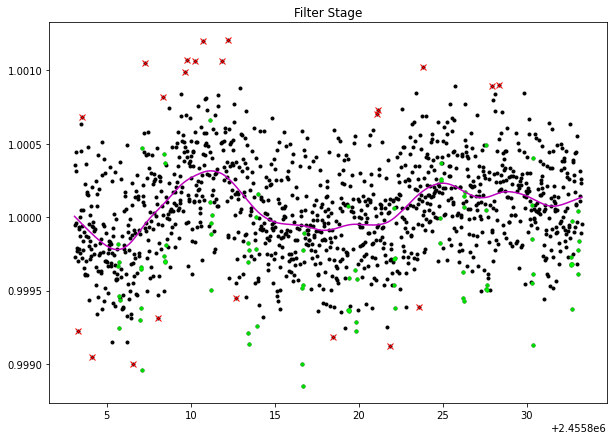

27
0.03946320801812863


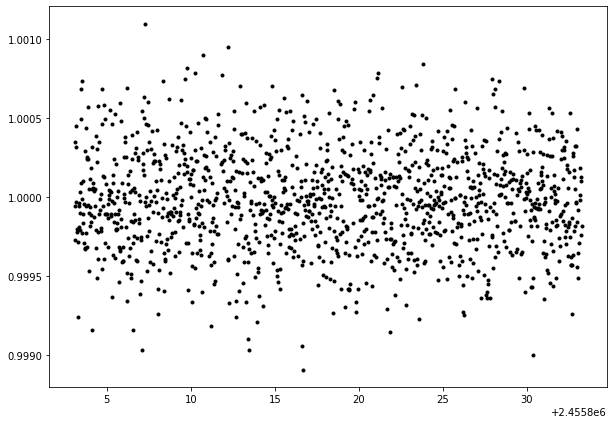

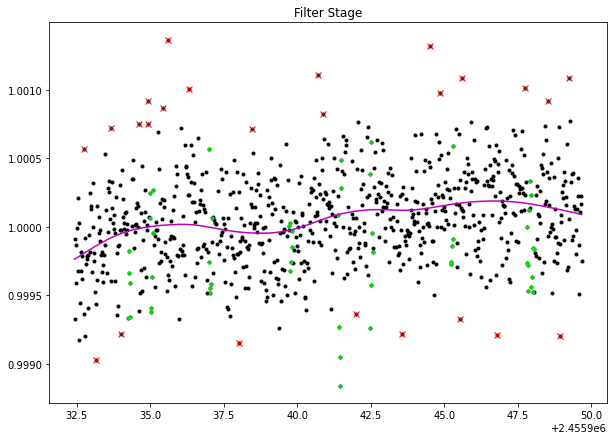

28
4.43012845326773e-08


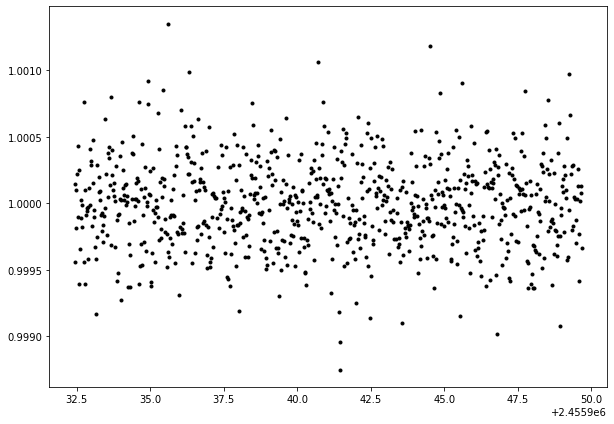

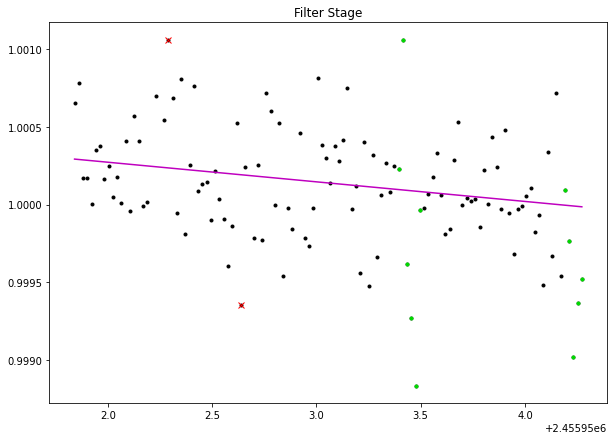

29
0.03682191550775093


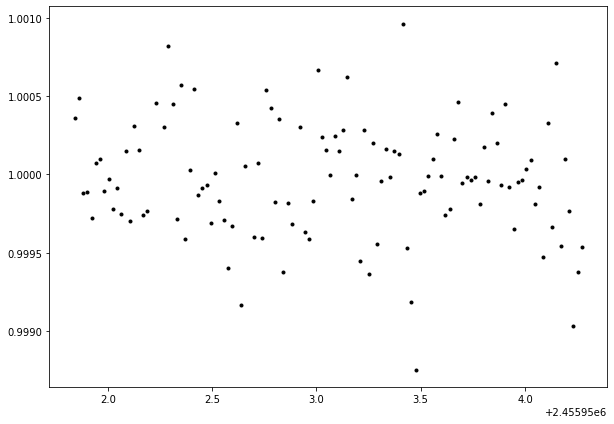

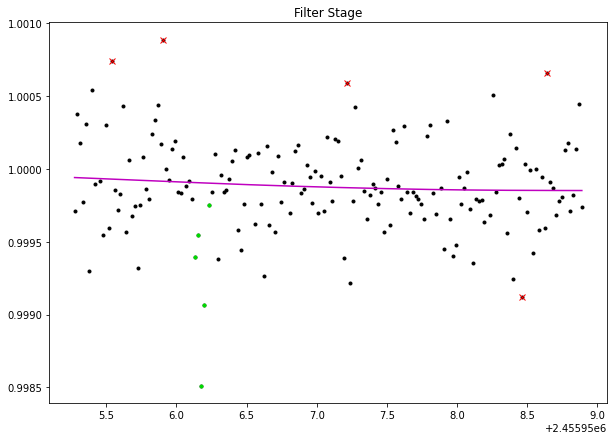

30
0.09930211879709377


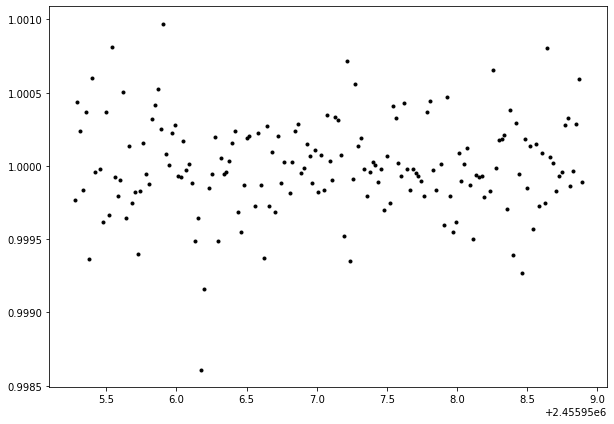

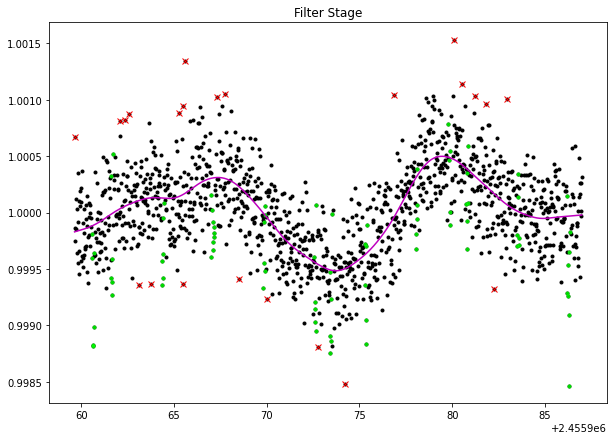

31
0.09134084291274445


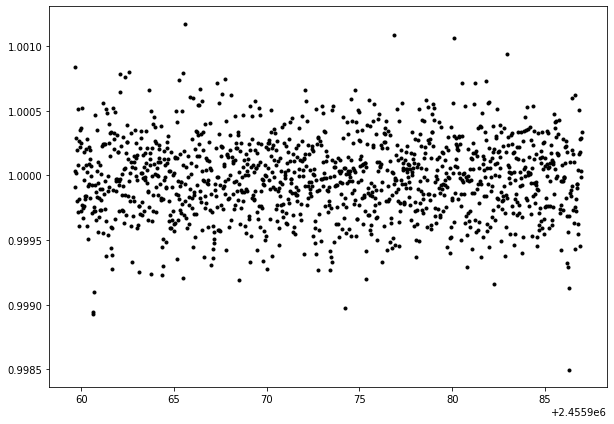

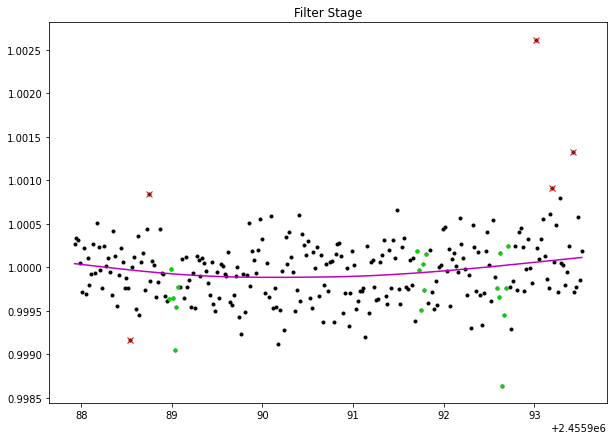

32
0.1725143890007522


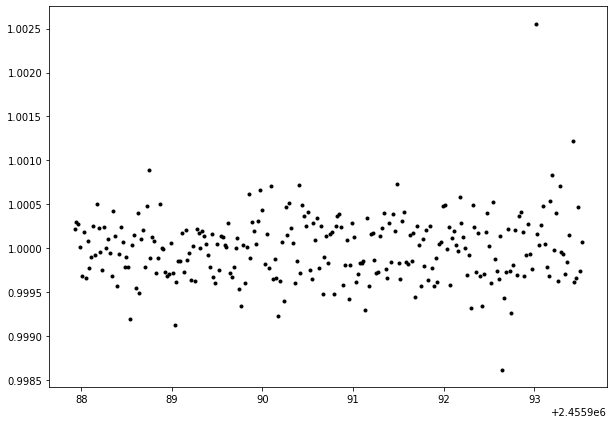

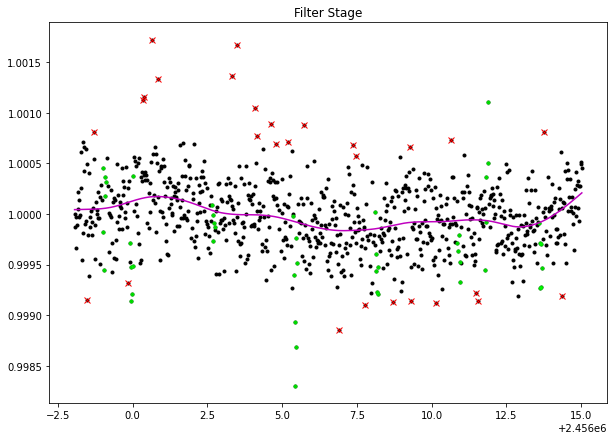

33
0.11909160877255218


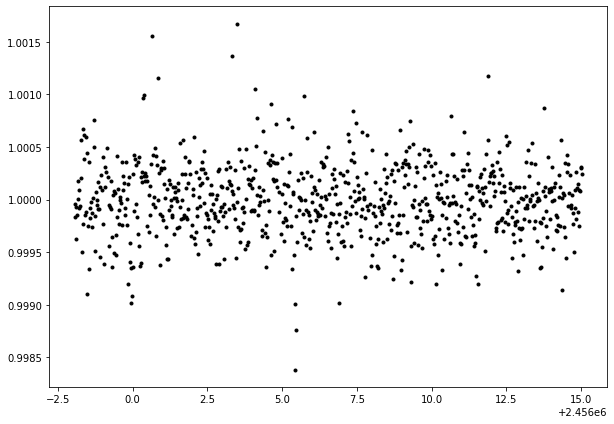

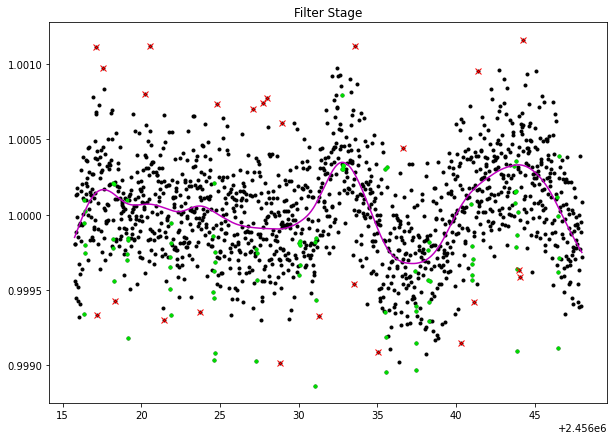

34
0.11326629235971394


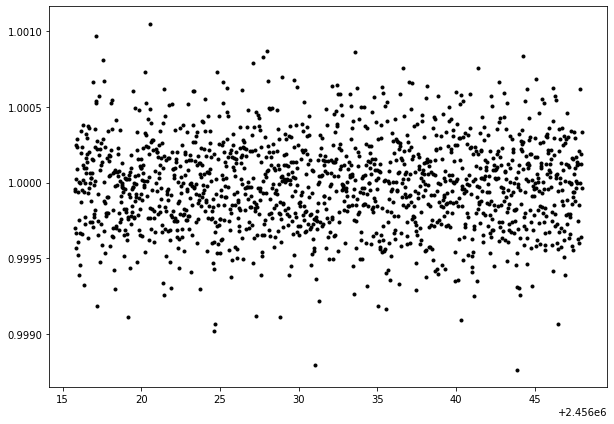

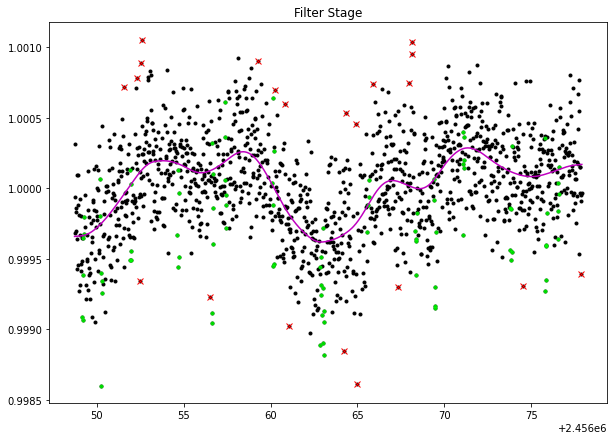

35
0.13881939869937385


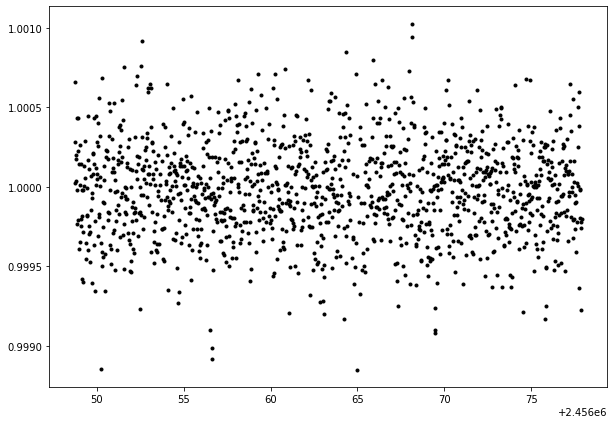

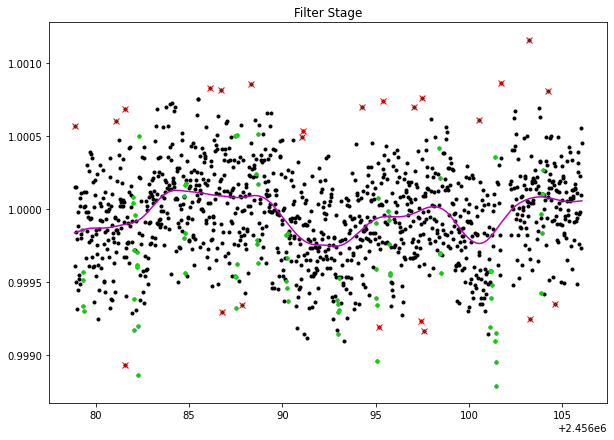

36
0.024352008835268907


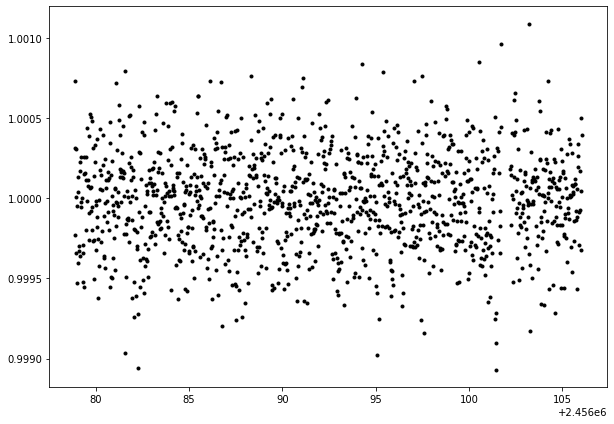

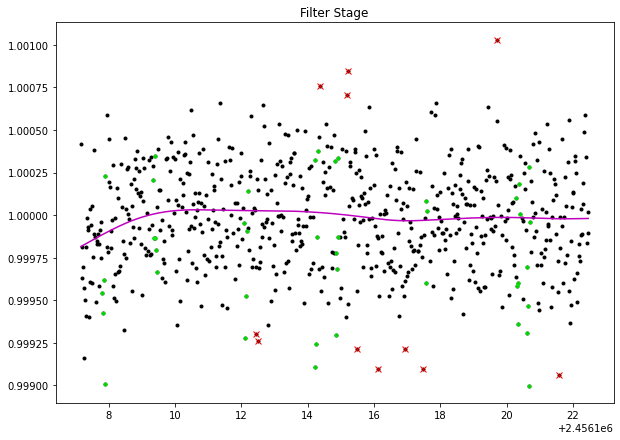

37
0.11631408283295068


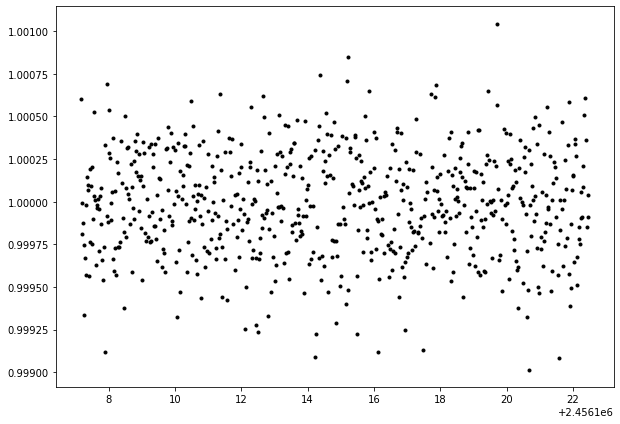

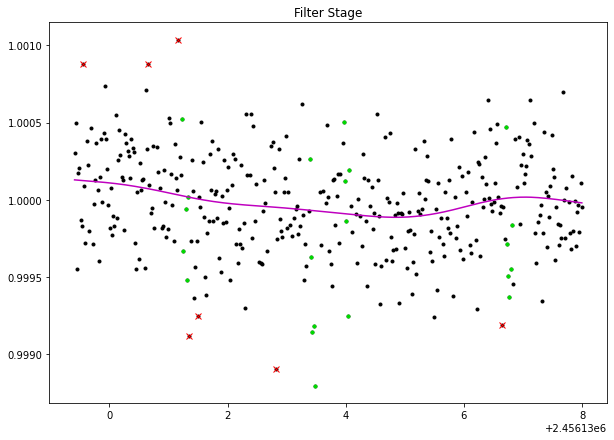

38
0.06551129821468633


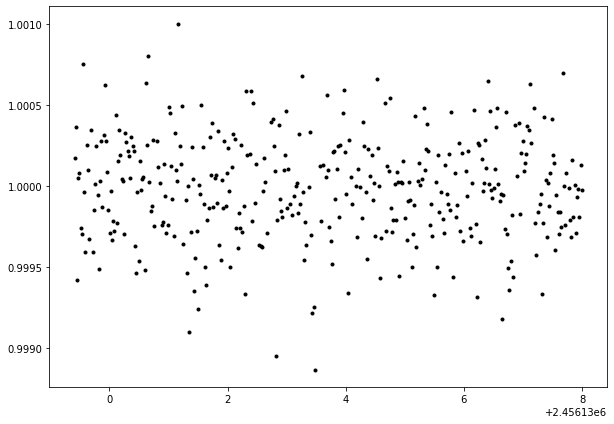

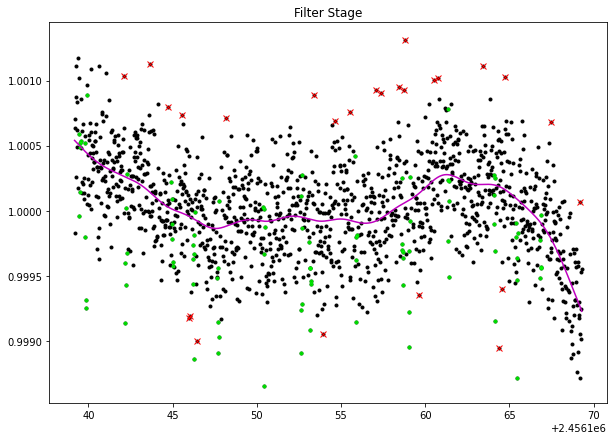

39
0.06887004716836004


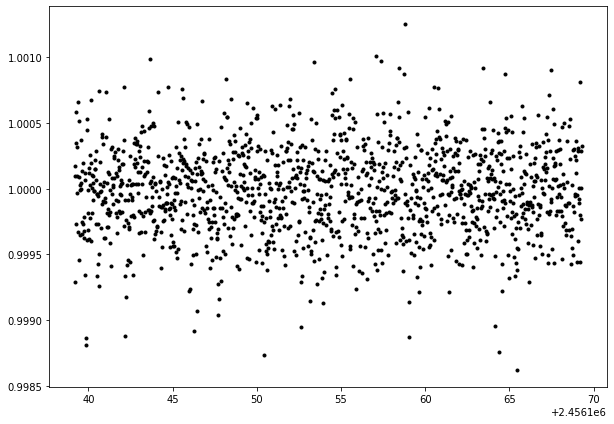

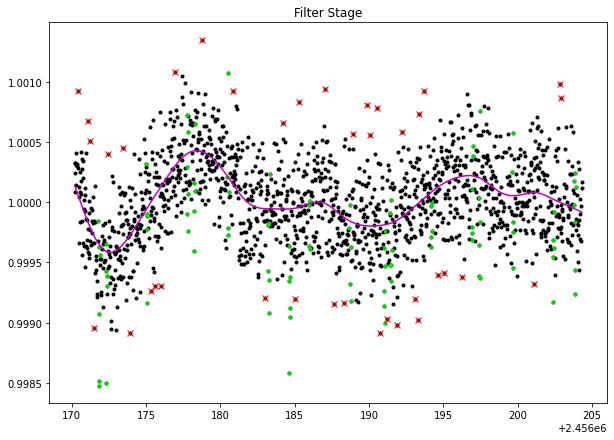

40
0.035291388996591413


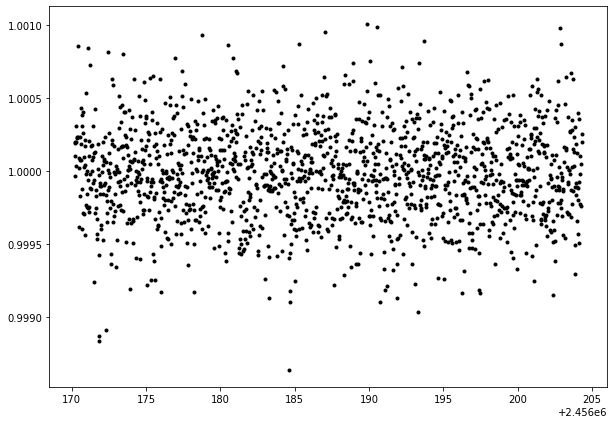

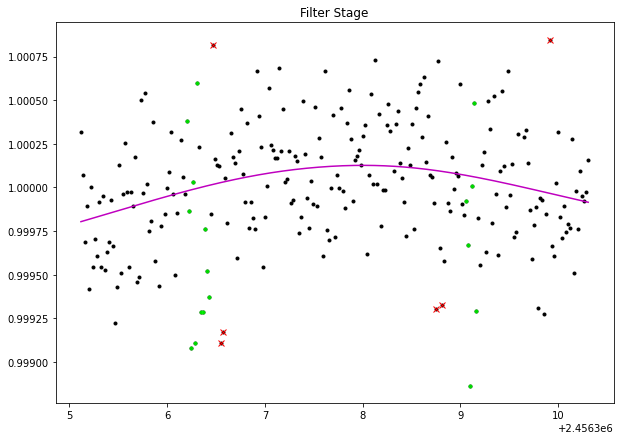

41
0.06747190531429853


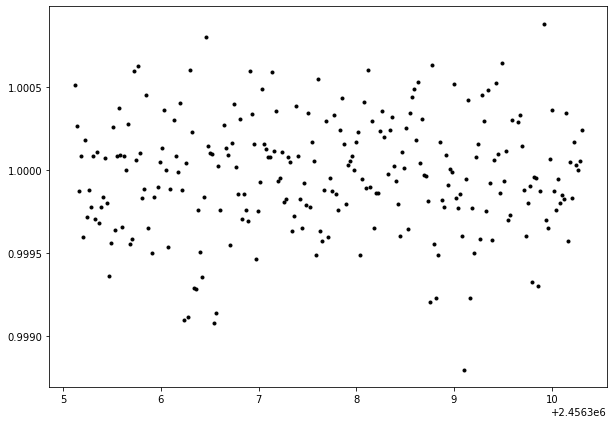

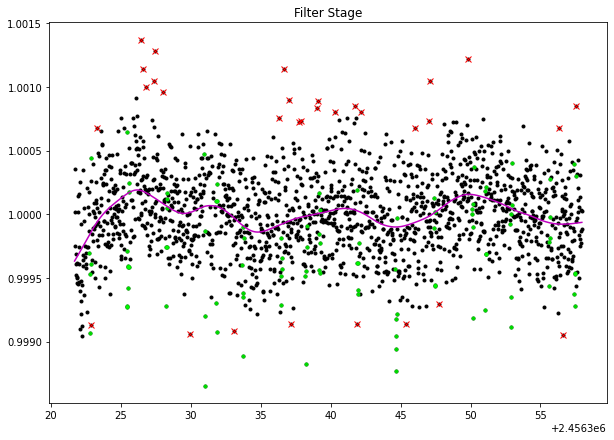

42
0.0631228843580648


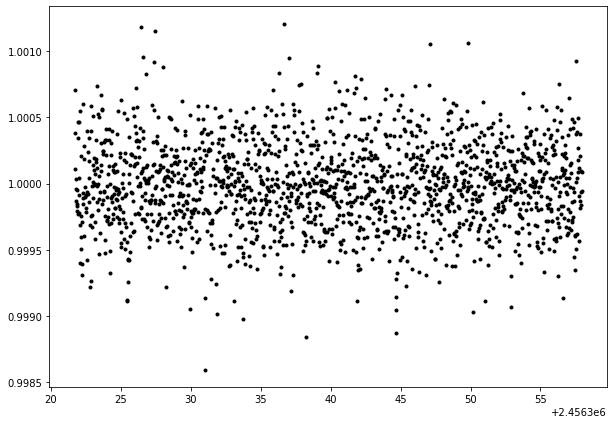

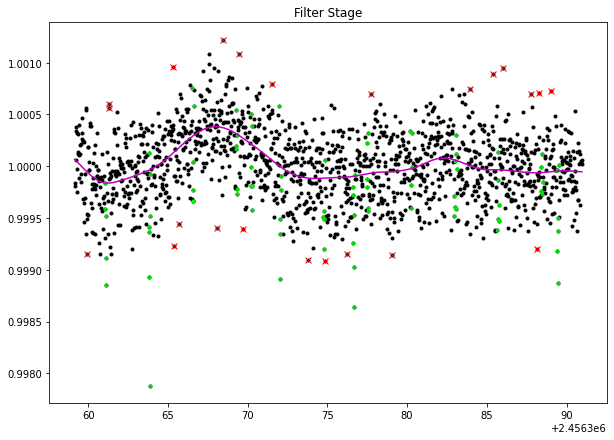

43
0.08249991428841896


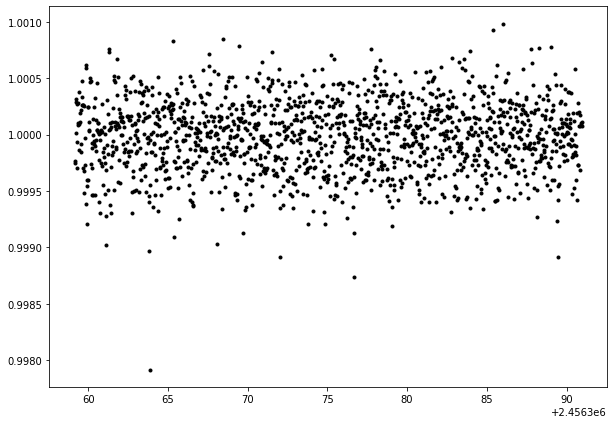

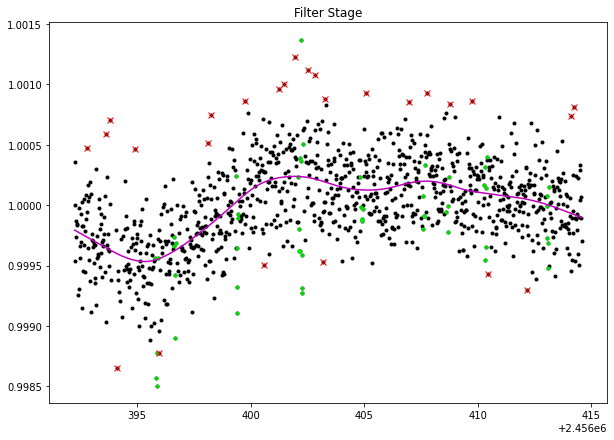

44
0.02869479709729196


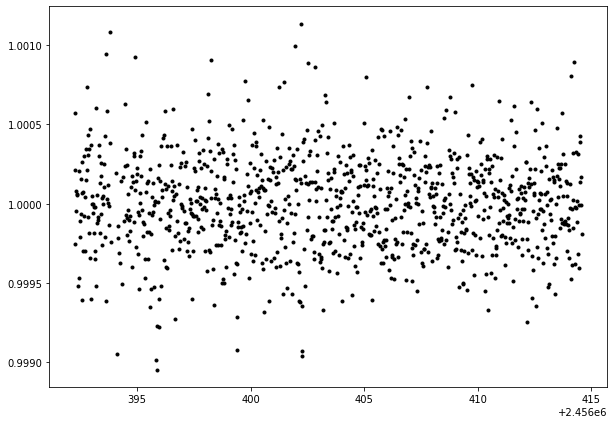

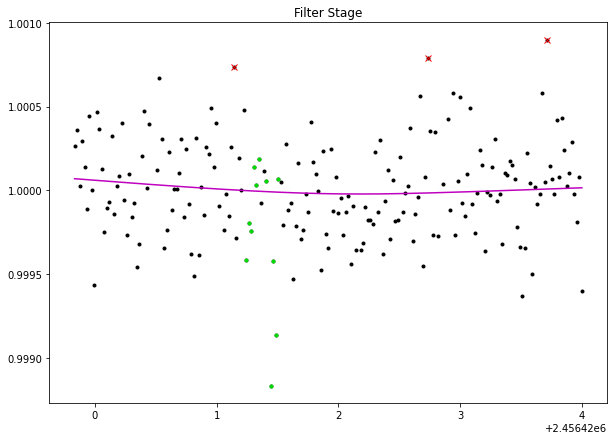

Done


In [155]:
#this plots out all the sections, see if there are some that are improperly fit like section 3
mask_transit_q = True

fit_sds = [7, 5.5, 4, 2.5] # Fitting iterative SD filter multiplers

#smooth_params_to_try = np.linspace(0.9, 1-1e-8, 200)[:-1]

#smooth_params_to_try = np.linspace(0.0001, 0.8, 200)[:-1]

smooth_bnds = [.00,.99] # Smoothing param range allowed
# smooth_bnds = [.00,.15] # Smoothing param range allowed
particular_smooth_bnds = []

print("THE SMOOTHING BOUND IS " + str(smooth_bnds) + " IS THIS DESIRED?" )
print("THE PARTICULAR SMOOTHING BOUND IS " + str(particular_smooth_bnds) + " IS THIS DESIRED?")
print(split_numbers)
solver_var_scaler = 100 # Dont touch. Does nothing, b.


smooth_bnds = [smooth_bnds[0] * solver_var_scaler, smooth_bnds[1] * solver_var_scaler]

for i in range(len(particular_smooth_bnds)):
    particular_smooth_bnds[i] = [particular_smooth_bnds[i][0], 
            particular_smooth_bnds[i][1]*solver_var_scaler, particular_smooth_bnds[i][2]*solver_var_scaler]
###################################################################################
# Fit each section
print([x,target_name])
#smos = np.copy(smooth_params_to_try) #np.linspace(0.999, 1-1e-10, 200)

cont_fit, time_norm, flux_norm, outliers = np.array([]), np.array([]), np.array([]), np.array([])

cont_fit_list, flux_norm_list, outliers_list = [], [], []

sigs, ssmos = [], []
%matplotlib inline
for cn in range(len(all_time)):
    
    iter_smooth_bnds = smooth_bnds
    
    for z in range(len(particular_smooth_bnds)):
        if particular_smooth_bnds[z][0] == cn:
            iter_smooth_bnds = [particular_smooth_bnds[z][1], particular_smooth_bnds[z][2]]
            print("SMOOTH BOUND FOR " + str(cn) + " IS: " + str(np.array(iter_smooth_bnds) / solver_var_scaler))
#for cn in range(20):

    #print(cn)

    # Mask the transit
    if mask_transit_q:

#         transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
#                                     time_bkjd=all_time[cn], 
#                                     flux=all_flux[cn], 
#                                     lc=None, return_index=True)
        
        transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, 
                                          duration_day=np.array(all_duration_day)*1.5, 
                                          time_bkjd=all_time[cn], 
                                          flux=all_flux[cn], 
                                          lc=None, 
                                          return_index=True)
        
    else:

        transit_idx = np.zeros(len(all_time[cn]), dtype=bool)


    #bics = np.ones_like(smos)
    
    weights = np.float64(~transit_idx)
        
    weights[weights==0.0] = 1e-5
    
    #print(len(all_time[cn]), len(all_flux[cn]), len(weights))

    #sigma = meas_sig(all_time[cn], all_flux[cn], weights, plot_q=0)
    
    sigma = rms(np.diff(all_flux[cn][~transit_idx]))

    mdt = np.median(np.abs(np.diff(all_time[cn])))

    if (len(all_time[cn]) > 500):# & (all_time[cn][-1] - all_time[cn][0] < 1.5):

        dt = mdt * 100
        
    elif len(all_time[cn]) < 50:

        dt = mdt * 10

    elif all_time[cn][-1] - all_time[cn][0] < 1.5:

        dt = (all_time[cn][-1] - all_time[cn][0]) / 4

    elif all_time[cn][-1] - all_time[cn][0] < 5:

        #dt = np.median(np.abs(np.diff(all_time[cn]))) * 10.1
        dt = (all_time[cn][-1] - all_time[cn][0]) / 4
    else:
        dt = 1 #mdt * 30

    bins = np.arange(all_time[cn][0], all_time[cn][-1] + 1, dt)

    t_bins = np.digitize(all_time[cn], bins) - 1
    
    sigs.append(sigma)



    res = minimize_scalar(min_smo, 
                          bounds=tuple(iter_smooth_bnds), 
                          method='bounded', 
                          args=(all_time[cn], 
                                  all_flux[cn], 
                                  weights, 
                                  transit_idx, 
                                  fit_sds, 
                                  sigma, 
                                solver_var_scaler, t_bins))

    #print(res)

    bsmo = res.x / solver_var_scaler
    
    ssmos.append(bsmo)
    print(cn)
    print(bsmo)
    # Make the final fit using the solved smoothing param
    cont_fit_tmp, outliers_tmp, fig = iter_filt_ssfit(all_time[cn], 
                                                 all_flux[cn], 
                                                 weights, 
                                                 ~transit_idx, 
                                                 bsmo, sds=fit_sds, 
                                                 return_filt_index=1, 
                                                 plot_q=1, save_plot_q = 1)

    
    #print(len(all_time[cn]), len(cont_fit_tmp))
    #print(fig_sect_dir)
    fig_sect_dir = os.path.join(fig_dir, "Section " + str(cn) + '.png')

    fig.savefig(fig_sect_dir)
    
    flux_norm_tmp = all_flux[cn] / cont_fit_tmp


    cont_fit_list.append(cont_fit_tmp)

    flux_norm_list.append(flux_norm_tmp)

    outliers_list.append(outliers_tmp)
    
    plt.figure(figsize=(10,7))
    plt.plot(all_time[cn], flux_norm_tmp, '.k')
sigs = np.array(sigs)
ssmos = np.array(ssmos)
%matplotlib notebook
print('Done')

In [ ]:
#delete_section()

In [156]:
end_clip = 30
print("WARNING! EDGE CLIP IS " + str(end_clip))
cont_fit, time_norm, flux_norm, outliers = np.array([]), np.array([]), np.array([]), np.array([])

for cn in range(len(all_time)):
    
    time_norm = np.concatenate((time_norm, all_time[cn][end_clip:-end_clip]))

    cont_fit = np.concatenate((cont_fit, cont_fit_list[cn][end_clip:-end_clip]))

    flux_norm = np.concatenate((flux_norm, flux_norm_list[cn][end_clip:-end_clip]))

    outliers = np.concatenate((outliers, outliers_list[cn][end_clip:-end_clip]))

WARNING! EDGE CLIP IS 30


0.08531928444559775

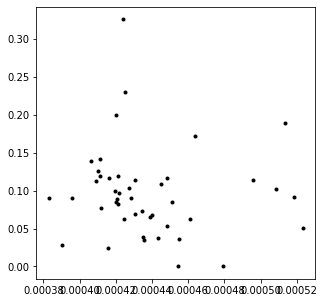

In [160]:
%matplotlib inline
#Saves the figure
plt.figure(figsize=(5, 5))
plt.plot(sigs, ssmos, '.k')
ax = plt.axes()
plt.ylim([.98,1])
#plt.savefig(os.path.join(fig_dir, "sigs_ssmos.png"))
ssmos[15]

%matplotlib inline
#Saves the figure
plt.figure(figsize=(5, 5))
plt.plot(sigs, ssmos, '.k')
plt.savefig(os.path.join(fig_dir, "sigs_ssmos.png"))
ssmos[15]

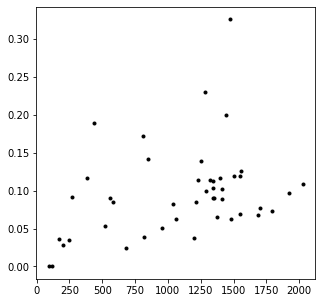

In [158]:
plt.figure(figsize=(5, 5))
plt.plot([len(all_time[i]) for i in range(len(all_time))], ssmos, '.k')

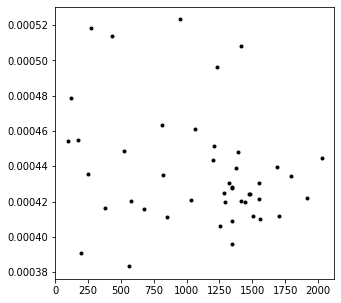

In [159]:
plt.figure(figsize=(5, 5))
plt.plot([len(all_time[i]) for i in range(len(all_time))], sigs, '.k')

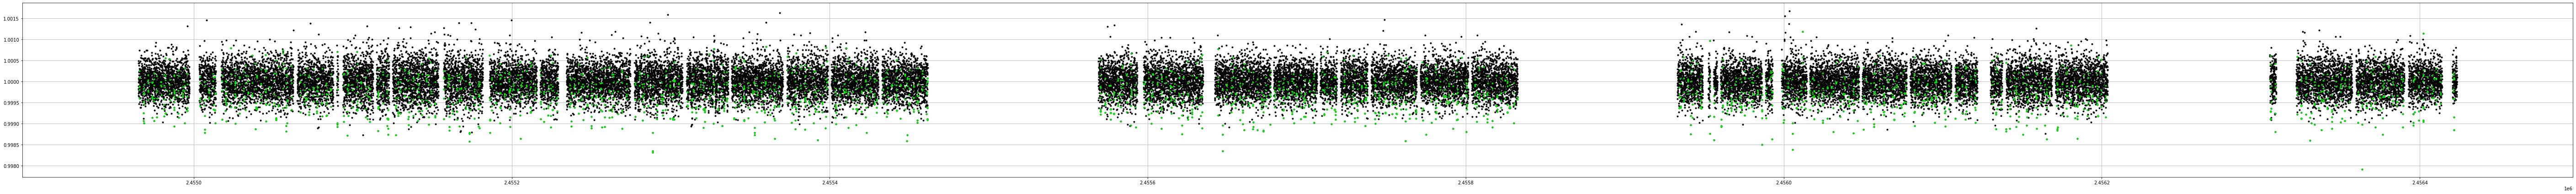

In [161]:
if plot_q:
    #Saves the figure
    # Mask the transit
    if mask_transit_q:

#         transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
#                                     time_bkjd=time_norm, flux=flux_norm, 
#                                     lc=None, return_index=True)
        
        transit_idx_final = mask_mulit_transits(all_t0_bkjd, all_period_day, 
                                          duration_day=np.array(all_duration_day)*1.5, 
                                          time_bkjd=time_norm, 
                                          flux=flux_norm, 
                                          lc=None, return_index=True)
        
    else:

        transit_idx_final = np.zeros(len(all_time[cn]), dtype=bool)

    plt.figure(figsize=(100, 7))

    #plt.plot(time_norm, flux_norm, '.k')
    plt.plot(time_norm, flux_norm, '.k')

    if mask_transit_q:
        plt.plot(time_norm[transit_idx_final], 
                 flux_norm[transit_idx_final], '.', 
                 c=[0,1,0,0.8], 
                 label='Transit (Area Masked During Fit)')

    plt.grid(1)
    plt.savefig(os.path.join(fig_dir, "Normalized With Transit Masks.png"))

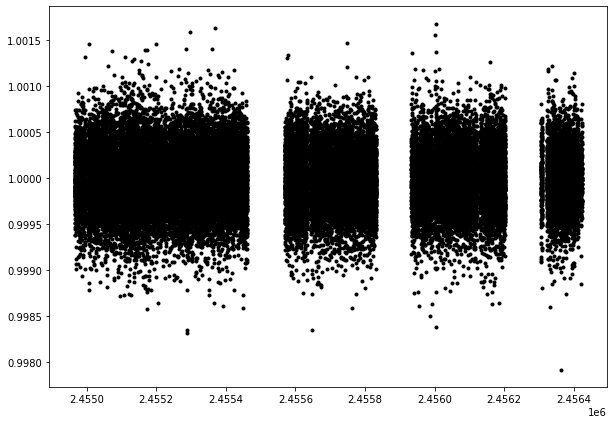

In [162]:
if plot_q:
    #Saves the figuer  
    # Mask the transit
    if mask_transit_q:

#         transit_idx = mask_transits(t0_bkjd=t0, period_day=p, duration_day=duration, 
#                                     time_bkjd=time_norm, flux=flux_norm, 
#                                     lc=None, return_index=True)
        
        transit_idx = mask_mulit_transits(all_t0_bkjd, all_period_day, 
                                          duration_day=all_duration_day, 
                                          time_bkjd=time_norm, 
                                          flux=flux_norm, 
                                          lc=None, return_index=True)
        
    else:

        transit_idx = np.zeros(len(all_time[cn]), dtype=bool)

    plt.figure(figsize=(10, 7))

    #plt.plot(time_norm, flux_norm, '.k')
    plt.plot(time_norm, flux_norm, '.k')
    plt.savefig(os.path.join(fig_dir, "Normalized.png"))

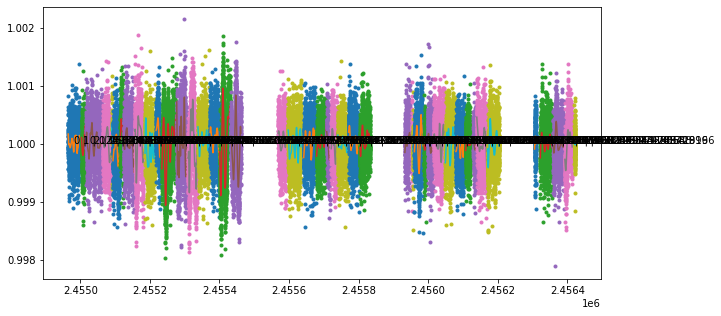

In [163]:
outliers = np.int8(outliers)

_, gi, _ = np.intersect1d(time, time_norm, return_indices=1)

gi = np.sort(gi)

plt.figure(figsize=(10, 5))

for cn in range(len(all_time)):
    
    t = all_time[cn][end_clip:-end_clip]
    f = all_flux[cn][end_clip:-end_clip]
    c = cont_fit_list[cn][end_clip:-end_clip]
    
    plt.plot(t, f, '.', t, c, '-')
    plt.text(np.mean(t), 1, str(cn) + ' | ' + str(ssmos[cn]), fontsize=10)

[   22    23    24 ... 46463 46464 46523]


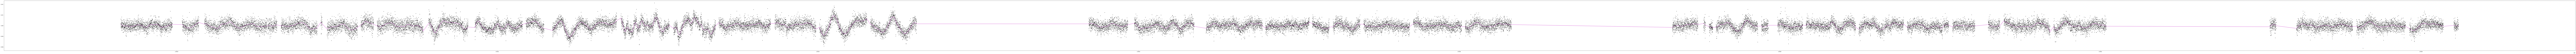

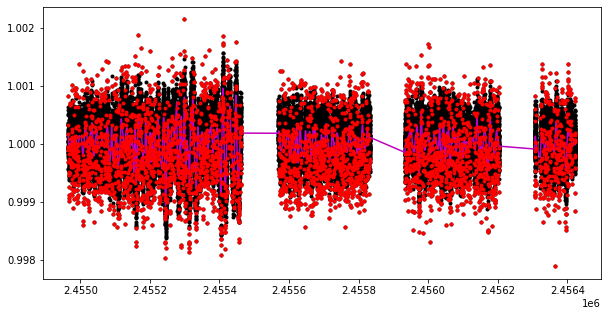

In [164]:
outliers = np.int8(outliers)
plot_outliers = np.where(outliers == True)[0]
print(plot_outliers)
_, gi, _ = np.intersect1d(time, time_norm, return_indices=1)

gi = np.sort(gi)
%matplotlib inline
#Saves the figure, you need to scrcoll when looking at it because its long
plt.figure(figsize=(500, 10))
plt.plot(time_norm, flux[gi], '.k')
plt.plot(time_norm, cont_fit, '-m')
plt.savefig(os.path.join(fig_dir, 'Final Fit.png'))
#%matplotlib notebook
plt.figure(figsize=(10, 5))
plt.plot(time_norm, flux[gi], '.k')
plt.plot(time_norm, cont_fit, '-m')
plt.plot(time_norm[plot_outliers], flux[gi][plot_outliers], '.r')

# SAVE NORMALIZED DATA

In [165]:
# Parameters
# save_dir = '/media/rd1/hwei/class_rv_lc/normalized_lcs/'
save_dir = '/media/rd3/cchen/cchen/kepler_ml_v3/2_normalize/lcs/'
kic_num = target_name
cadence = 'long'
version = 1

# Function
file_name = 'KIC' +  str(kic_num) + '_' +  cadence + '_v' + str(version) + '.npz'

# Check for this file's existence. If it does already exist, increment the version number as needed.
from os.path import isfile
while isfile(save_dir + file_name):
    # This file already exists. Let's increment the version number before saving.
    version += 1 
    file_name = 'KIC' +  str(kic_num) + '_' +  cadence + '_v' + str(version) + '.npz'  

note1 = "None"
full_path  = save_dir + file_name

In [168]:
np.savez(full_path, time=time_norm, flux=flux_norm, origin=person_id, note1=note1, transit_ids = transit_idx_final, splits = split_numbers)

/media/rd3/cchen/cchen/kepler_ml_v3/2_normalize/lcs/KIC10554999_long_v1.npz
cchen
None
[2455127]


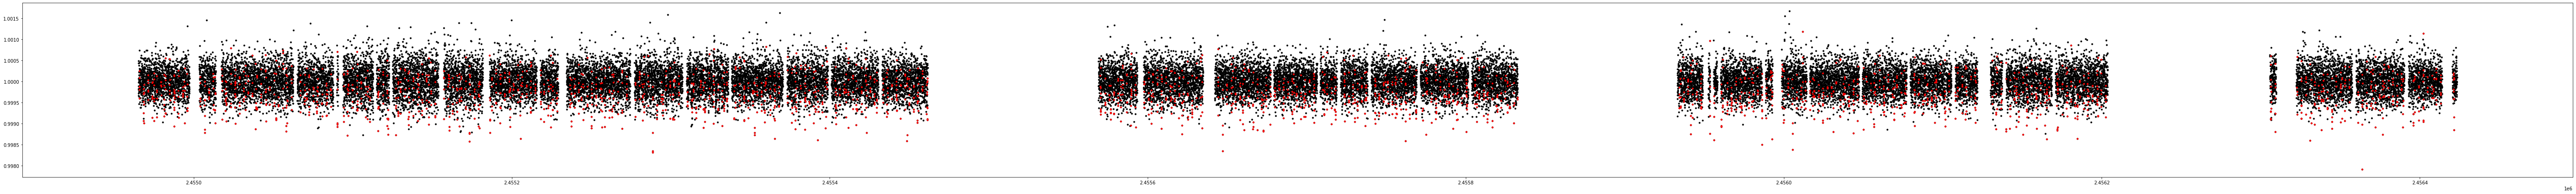

In [169]:
#VERIFY NPZ FILE CREATION
loaded_file = np.load(full_path)
print(full_path)

time_better_be_temporary =  loaded_file['time']
flux_better_be_temporary =  loaded_file['flux'] 
origin_better_be_temporary =  loaded_file['origin'] 
note1_better_be_temporary =  loaded_file['note1']   
transit_ids_better_be_temporary = loaded_file['transit_ids']
splits_better_be_temporary = loaded_file['splits']

print(origin_better_be_temporary)
print(note1_better_be_temporary)
print(splits_better_be_temporary)
plt.figure(figsize = (100,7))
plt.plot(time_better_be_temporary, flux_better_be_temporary, '.k')
plt.plot(time_better_be_temporary[transit_ids_better_be_temporary], flux_better_be_temporary[transit_ids_better_be_temporary], '.r')

# AT THIS POINT YOU CAN JUST RESTART THE NOTEBOOK AND DO EVERYTHING OVER AGAIN